In [1]:
import sys
import torch
sys.path.append("../")
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
import cv2
from lib.linear_gromov import LGW_dist,LPGW_embedding,LPGW_dist,LGW_dist
from lib.opt import opt_lp,emd_lp
from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty
from utils import *
#from lib.lgw.utils import *
from ot.gromov import init_matrix
#from ot.gromov._utils import init_matrix
#from ot.gromov import cg,gwggrad,gwloss,init_matrix

In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

def normalize(X):
    M=cost_matrix_d(X,X)
    return X/np.sqrt(M.max())

Current working directory: /home/baly/projects/Linearized_Partial_Gromov_Wasserstein/ellipses


In [3]:
# Define parameters
Nx = 10
Ny = 10
N = Nx * Ny
x_len = 50
y_len = 50

In [4]:
# Load ellipses
ells = np.loadtxt("./ellipses_data.txt").reshape((Nx,Ny,x_len,y_len))
ells.shape

(10, 10, 50, 50)

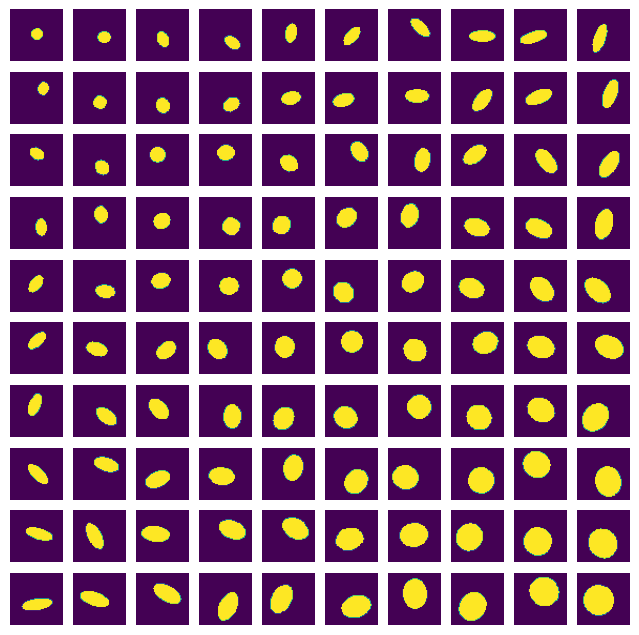

In [10]:
# Plot ellipses
fig, ax = plt.subplots(Nx, Ny, figsize=(8,8))
for i in range(Nx):
    for j in range(Ny):
        ax[i, j].imshow(ells[i, j])
        ax[i, j].set_axis_off()

import numpy as np
from sklearn.cluster import KMeans

# Assuming your point cloud is stored in a variable called `point_cloud`
# point_cloud is of shape (2000, 3)

def reduce_point_cloud(point_cloud, n_clusters,seed=0):
    n=point_cloud.shape[0]
    if n_clusters==n:
        return point_cloud
    if n_clusters>n:
        point_cloud=np.concatenate((point_cloud,point_cloud))
        return reduce_point_cloud(point_cloud, n_clusters,seed=0)
    np.random.rand(seed)
    # Initialize the KMeans algorithm with the desired number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init='auto')
    
    # Fit the model to the point cloud
    kmeans.fit(point_cloud)
    
    # The cluster centers are the reduced point cloud
    reduced_point_cloud = kmeans.cluster_centers_
    
    return reduced_point_cloud

def normalize_point_cloud(pcd):
    C=cost_matrix_d(pcd,pcd)
    C=np.sqrt(C)
    return pcd/C.max()

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (96) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


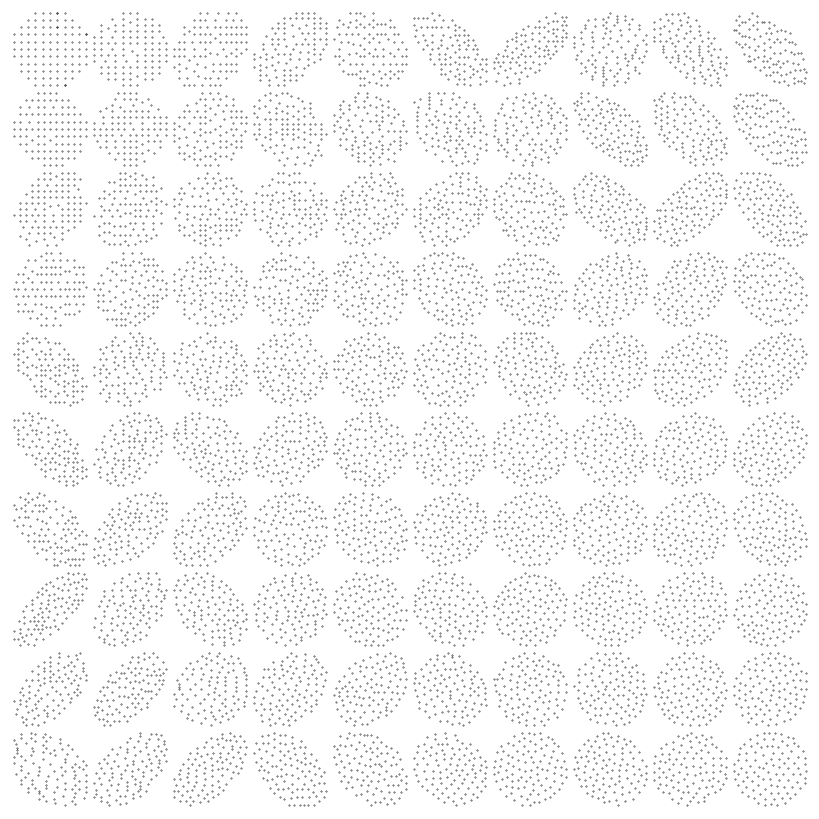

(100, 100)
0.9999999999999998
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
# Create mm-spaces from imgs (we will noamalize the distance)
ells_flat = ells.reshape(N,x_len,y_len)

posns = []
heights = []
Ms = []
LAMBDA_MAX = 0

size=100
for i in range(N):
    img = ells_flat[i]
    supp,M,height=mm_space_from_img(img, normalize_meas=False)
    supp2=reduce_point_cloud(supp,size)
    supp2=normalize_point_cloud(supp2)
    M=np.sqrt(cost_matrix_d(supp2,supp2))
    height=np.ones(supp2.shape[0])
    height=height/height.sum()
    posns.append(supp2)
    heights.append(height)
    Ms.append(M)
    LAMBDA_MAX = max(LAMBDA_MAX, Ms[i].max() ** 2)

# Plot ellipses
fig, ax = plt.subplots(Nx, Ny, figsize=(8,8))
for i in range(Nx):
    for j in range(Ny):
        data=posns[i*10+j]
        ax[i, j].scatter(data[:,0],data[:,1],s=0.1,color='black')
        ax[i,j].axis('off') 
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
        
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

plt.savefig("data/ellipse.png",dpi=200)
plt.show()

# refs=torch.load('data/refs.pt')

# verify the correctness 
i=20 
print(Ms[i].shape)
print(Ms[i].max())
print(Ms[i]-np.sqrt(cost_matrix_d(posns[i],posns[i])))

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (52) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


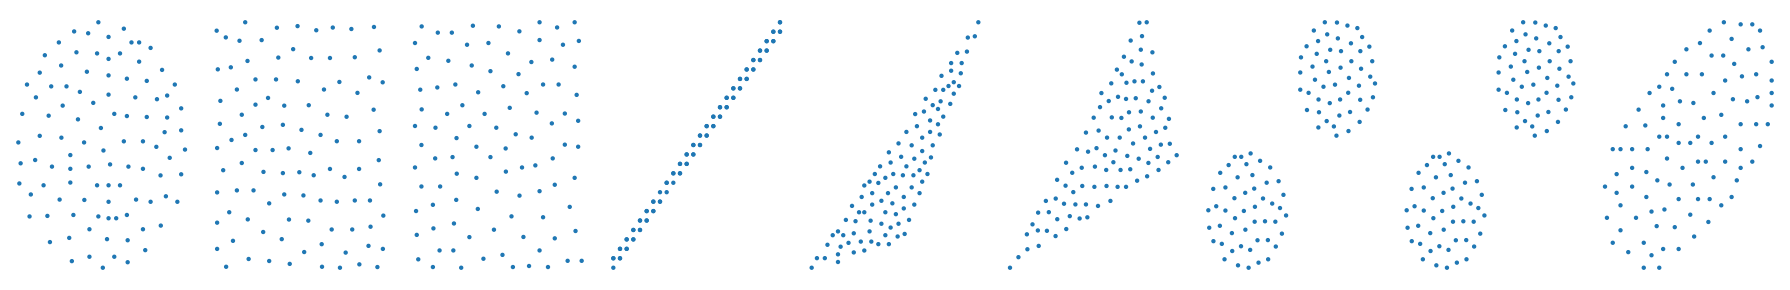

(100, 100)
0.9999999999999998
0.0


In [32]:
# Plot ellipses
refs=torch.load('data/refs.pt')

# normalize refs
refs2=[]
for (supp,M,height) in refs:
    supp2=reduce_point_cloud(supp,size)
    supp2=normalize_point_cloud(supp2)
    M=np.sqrt(cost_matrix_d(supp2,supp2))
    height=np.ones(supp2.shape[0])
    height=height/height.sum()
    refs2.append((supp2,M,height))

    
# Create a 9x1 subplot
fig, axes = plt.subplots(1, 9, figsize=(18, 3))
# Plotting each scatter plot in the subplots
for i, ax in enumerate(axes):
    supp,M,height=refs2[i]
    M_max=M.max()
    supp=supp/M_max
    ax.scatter(supp[:, 0], supp[:, 1],s=height*450)
    #ax.set_title(f'Scatter Plot {i + 1}')
    #ax.grid(True)
    ax.axis('off') 
    ax.set_xticks([])
    ax.set_yticks([])
    
        
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)



plt.tight_layout()
plt.show()


i=2
supp,M,height=refs2[i]
print(M.shape)
print(M.max())
print(np.linalg.norm(M-np.sqrt(cost_matrix_d(supp,supp))))


In [33]:
###### Compute LPGW distances for all reference measures
def LPGW_dist(embedding1,embedding2,Lambda):
    (K1_tilde,p1_tilde,mass_p1c),(K2_tilde,p2_tilde,mass_p2c)=embedding1,embedding2
    p12=np.minimum(p1_tilde,p2_tilde)
    M=(K1_tilde-K2_tilde)**2 
    dist=p12.dot(M).dot(p12.reshape(-1,1))[0]
    penalty_1=Lambda*(p1_tilde.sum()**2+p2_tilde.sum()**2-2*p12.sum()**2)
    penalty_2=Lambda*(mass_p1c+mass_p2c)
    return dist, penalty_1+penalty_2

def normalize_pmf(height,total_mass=False,alpha=1.0/300):
    if total_mass==True:
        return height/height.sum()
    elif total_mass==False:
        return height/height.mean()*alpha


loss='sqrt'
        
import time
import numpy as np
save_path='results_nl_np_ns'

st = time.time()        
refs=torch.load('data/refs.pt')
WEIGHT=size
N=100
beta_list=[0.01,0.03,0.05,0.1,0.3,0.5]

print('start')
for beta in beta_list:
    Lambda=beta*LAMBDA_MAX
    dist=np.zeros((N,N))
    for i in range(N):
        M1 = Ms[i]
        height1 = normalize_pmf(heights[i],alpha=1/size)
        n=height1.shape[0]
        for j in range(i + 1, N):
            print('i is %i, j is %i'%(i,j),end='\r')
            M2=Ms[j]
            height2 = normalize_pmf(heights[j],alpha=1/size)
            M_ot = ot.dist(posns[i],posns[j])
            G0 = ot.emd(height1,height2,M_ot)
        
            #constC, hC1, hC2 = init_matrix(M1, M2, height1, height2, "square_loss")
        
            gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=G0, Lambda=Lambda, thres=1, numItermax=500 * n,numItermax_gw=2000, tol=1e-10, log=False, verbose=False, line_search=True)
            pgw_trans, pgw_penalty = PGW_dist_with_penalty(M1, M2, gamma, height1, height2, Lambda)
            #P = ot.gromov.gromov_wasserstein(M1,M2,height1,height2,"square_loss",log=False, armijo=False,tol=1e-10)
            #D2=GW_dist(M1,M2,P)
            dist[i, j] = np.sqrt(pgw_trans + pgw_penalty)
            # if i==0 and j==1:
            #     gamma = gromov_wasserstein(M1, M2, height1, height2, G0=None, thres=1, numItermax=500 * n,numItermax_gw=2000, tol=1e-10, log=False, verbose=False, line_search=True)
            #     gw = GW_dist(M1, M2, gamma)
            #     print('gw-pgw',np.sqrt(gw)-dist[i, j])

            #     P = ot.gromov.gromov_wasserstein(M1,M2,height1,height2,"square_loss",log=False, armijo=False,tol=1e-10)
            #     D2=GW_dist(M1,M2,P)
            #     print('gw-pgw',np.sqrt(D2)-dist[i, j])

#    dist[dist < 0] = 0
    dist += dist.T
    et = time.time()
    wall_time = et - st
    print(f"PGW computation for Lambda {Lambda}: {np.round(wall_time/60, 2)} min")
    result={}
    result['dist'],result['wall_time']=dist,wall_time
    torch.save(result,save_path+'/pgw_%0.3f.pt'%Lambda)


    # # compute the LPGW 
    dist_per_ref = []
    times_per_ref = []
    # compute the embeddings
    for k in range(len(refs2)):
        embeddings=[]
        supp,M,height = refs2[k]
        M_max=M.max()
        supp=supp/M_max
        M=M/M_max
        
        #normalize the references

        height1=normalize_pmf(height,alpha=1/size) 
        
        st = time.time()

        n=height1.shape[0]
        for i in range(N):
            #compute the embedding
            height2=normalize_pmf(heights[i],alpha=1/size) #/heights[i].mean()* 1/WEIGHT #heights[i].sum() # #
            supp2= posns[i]
            #Compute Wasserstein coupling
            M_ot = ot.dist(supp,supp2)
#            M_ot = ot.dist(posns[i],posns[j])
            G0 = ot.emd(height1,height2,M_ot)
            
#           G0,_= opt_lp(height1,height2,M_ot,Lambda)
            G =partial_gromov_ver1(M, Ms[i], height1, height2, G0=G0,Lambda=Lambda,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-10,log=False, verbose=False,line_search=False) 
            embedding,_=LPGW_embedding(M,supp2,height1,height2,Lambda,gamma=G,loss=loss)
            embeddings.append(embedding)

            
        dist2 = np.zeros((N,N))
        for i in range(N):
            embedding1=embeddings[i]
            for j in range(i + 1, N):
                embedding2=embeddings[j]
                trans,penalty=LPGW_dist(embedding1,embedding2,Lambda)
                dist2[i, j] = np.sqrt(trans+penalty)

        dist2 += dist2.T
        et = time.time()
        print("Time for LPGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")

        times_per_ref.append(et-st)
        dist_per_ref.append(dist2)

    result={}
    result['dist_per_ref'],result['times_per_ref']=dist_per_ref,times_per_ref
    torch.save(result,save_path+'/lpgw_%0.3f.pt'%Lambda)

start
PGW computation for Lambda 0.010000000000000005: 2.78 min
Time for LPGW with ref space 0: 0.22 min
Time for LPGW with ref space 1: 0.15 min
Time for LPGW with ref space 2: 0.11 min
Time for LPGW with ref space 3: 4.49 min
Time for LPGW with ref space 4: 1.34 min
Time for LPGW with ref space 5: 0.19 min
Time for LPGW with ref space 6: 0.11 min
Time for LPGW with ref space 7: 0.11 min
Time for LPGW with ref space 8: 0.08 min
PGW computation for Lambda 0.030000000000000013: 2.01 min
Time for LPGW with ref space 0: 0.08 min
Time for LPGW with ref space 1: 0.07 min
Time for LPGW with ref space 2: 0.06 min
Time for LPGW with ref space 3: 1.53 min
Time for LPGW with ref space 4: 0.08 min
Time for LPGW with ref space 5: 0.07 min
Time for LPGW with ref space 6: 0.13 min
Time for LPGW with ref space 7: 0.2 min
Time for LPGW with ref space 8: 0.1 min
PGW computation for Lambda 0.050000000000000024: 2.16 min
Time for LPGW with ref space 0: 0.07 min
Time for LPGW with ref space 1: 0.07 min
Ti

In [34]:
for beta in beta_list:
    Lambda=beta*LAMBDA_MAX
    print('Lambda is',Lambda)
    result=torch.load(save_path+'/pgw_%0.3f.pt'%beta)
    print(save_path+'/pgw_%0.3f.pt'%beta)
    pgw=result['dist']
    #pgw=pgw/pgw.max()
    time_pgw=result['wall_time']
    result=torch.load(save_path+'/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    print('wall_clock time in min for PGW is', time_pgw/60)
    print("        MRE       PCC      time in mins     no. of points")
    for i in range(9):
        lpgw=lpgw_per_ref[i]
        #lpgw=lpgw/lpgw.max()
        m_pgw = np.ma.masked_equal(pgw, 0.0, copy=False)
        m_lpgw = np.ma.masked_equal(lpgw, 0.0, copy=False)
        print("Ref " + str(i+1) + ":  " 
              + str(np.round(np.mean(np.abs(m_pgw - m_lpgw)/m_pgw),4)) 
              + "    " 
              + str(np.round(np.corrcoef(m_pgw.flatten(),m_lpgw.flatten())[1,0],4))
              + "    "
              + str(np.round((times_per_ref[i])/60,2))
              + "             "
              + str(refs[i][2].shape[0]))


Lambda is 0.010000000000000005
results_nl_np_ns/pgw_0.010.pt
wall_clock time in min for PGW is 2.7750357071558636
        MRE       PCC      time in mins     no. of points
Ref 1:  0.3669    0.5749    0.22             441
Ref 2:  0.3601    0.7296    0.15             676
Ref 3:  0.35    0.7263    0.11             625
Ref 4:  0.8803    0.3243    4.49             52
Ref 5:  0.7069    0.409    1.34             289
Ref 6:  0.5866    0.459    0.19             545
Ref 7:  0.6274    0.4974    0.11             882
Ref 8:  0.6274    0.4974    0.11             882
Ref 9:  0.3064    0.6055    0.08             317
Lambda is 0.030000000000000013
results_nl_np_ns/pgw_0.030.pt
wall_clock time in min for PGW is 2.008752413590749
        MRE       PCC      time in mins     no. of points
Ref 1:  0.4797    0.5376    0.08             441
Ref 2:  0.4299    0.6523    0.07             676
Ref 3:  0.4347    0.6477    0.06             625
Ref 4:  1.1283    0.3802    1.53             52
Ref 5:  0.836    0.5092   

In [118]:
# compute  GW distance
st = time.time()        
dist = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i]
    height1 = heights[i] / np.sum(heights[i])
    n=height1.shape[0]
    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j] / np.sum(heights[j])
        gamma = gromov_wasserstein(M1, M2, height1, height2, G0=None,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=True)
        dist[i, j] = np.sqrt(GW_dist(M1, M2, gamma))
        if i==0 and j==4:
            print('dist at 0, 4 is ', dist[i,j])
            
dist += dist.T
et = time.time()
wall_time=np.round(et-st,2)

result={}
result['dist'],result['wall_time']=dist,wall_time
torch.save(result,'results/gw.pt')


dist at 0, 4 is  0.1318223599871315


KeyboardInterrupt: 

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


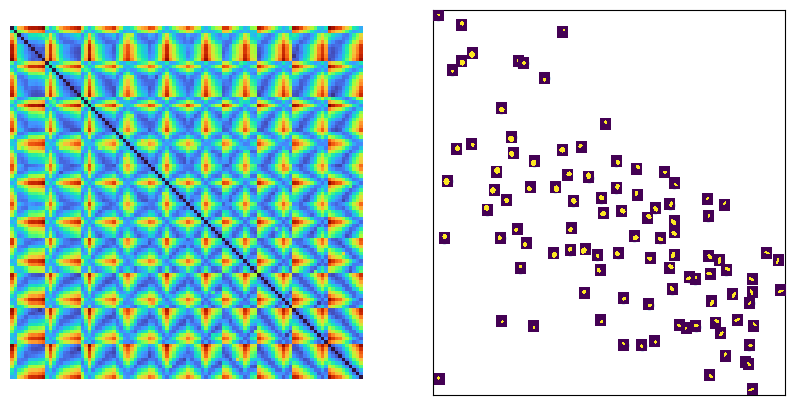

In [35]:
# Plot
result=torch.load('results_save/gw.pt')
gw,gw_time=result['dist'],result['wall_time']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gw,cmap = "turbo")
ax[0].axis("off")


mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(gw)
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()


In [36]:
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def smacof_mds(C, dim, max_iter=3000, eps=1e-9,seed=0):
    """
    "" This code is imported from PythonOT: Gromov-Wasserstein Barycenter example 
    https://pythonot.github.io/auto_examples/gromov/plot_gromov_barycenter.html
    
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

   #rng = np.random.RandomState(seed=3)
   # seed=seed
    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        normalized_stress='auto',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress='auto',
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos
def plot_2d_shape_embedding(data, embedding, min_dist, figsize, cutoff=5, font_size=16, labels=None, save_path=None, col=None, show_numbers=False, padwidth=2, return_img=False, axex=None):
    # Cut outliers
    n_pts = data.shape[0]
    n_dims = data.shape[1]
    low = [np.percentile(embedding[:, 0], q=cutoff), np.percentile(embedding[:, 1], q=cutoff)]
    high = [np.percentile(embedding[:, 0], q=100 - cutoff), np.percentile(embedding[:, 1], q=100 - cutoff)]
    cut_inds = np.arange(n_pts)[(embedding[:, 0] >= low[0]) * (embedding[:, 0] <= high[0])
                                * (embedding[:, 1] >= low[1]) * (embedding[:, 1] <= high[1])]

    data = data[cut_inds, :]
    embedding = embedding[cut_inds, :]

    # Visualize
    fig_x, fig_y = figsize
    fig_ratio = fig_x / fig_y
    #fig = plt.figure(figsize=(fig_x, fig_y))
    #ax = fig.add_subplot(111)

    # Plot images
    img_scale = 0.03
    pixels_per_dimension = int(np.sqrt(n_dims))

    x_size = (max(embedding[:, 0]) - min(embedding[:, 0])) * img_scale
    y_size = (max(embedding[:, 1]) - min(embedding[:, 1])) * img_scale * fig_ratio
    shown_images = np.array([[100., 100.]])

    if labels is not None:
        NUM_COLORS = len(np.unique(labels))
        cm = plt.get_cmap('gist_rainbow')
        unique_labels = np.unique(labels)

    for i in range(n_pts):
        #         dist = np.sqrt(np.sum((embedding[i] - shown_images) ** 2, axis=1))
        # don't show points that are too close
        #         if np.min(dist) < min_dist:
        #             continue
        #         shown_images = np.r_[shown_images, [embedding[i]]]
        x0 = embedding[i, 0] - (x_size / 2.)
        y0 = embedding[i, 1] - (y_size / 2.)
        x1 = embedding[i, 0] + (x_size / 2.)
        y1 = embedding[i, 1] + (y_size / 2.)
        if col is None:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension)
        else:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension,3)
        #print(np.shape(data[i,:]))
        if labels is not None:
            j = list(unique_labels).index(labels[i])
            col_lab = cm(1.*j/NUM_COLORS)[:3]
            img = np.pad(img.astype(float), (padwidth,padwidth), "constant", constant_values=-1)
            img = np.array([np.array([[x/255,x/255,x/255] if x != -1 else col_lab for x in tmp]) for tmp in img])
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1),cmap="viridiris")
        else:
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
        if show_numbers:
            plt.text(x1, y1, str(i), color="black", fontdict={"fontsize":10,"fontweight":'bold',"ha":"left", "va":"baseline"})


    # scatter plot points
    axex.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=150, alpha=0.5)
    axex.tick_params(axis='both', which='major', labelsize=font_size - 4)

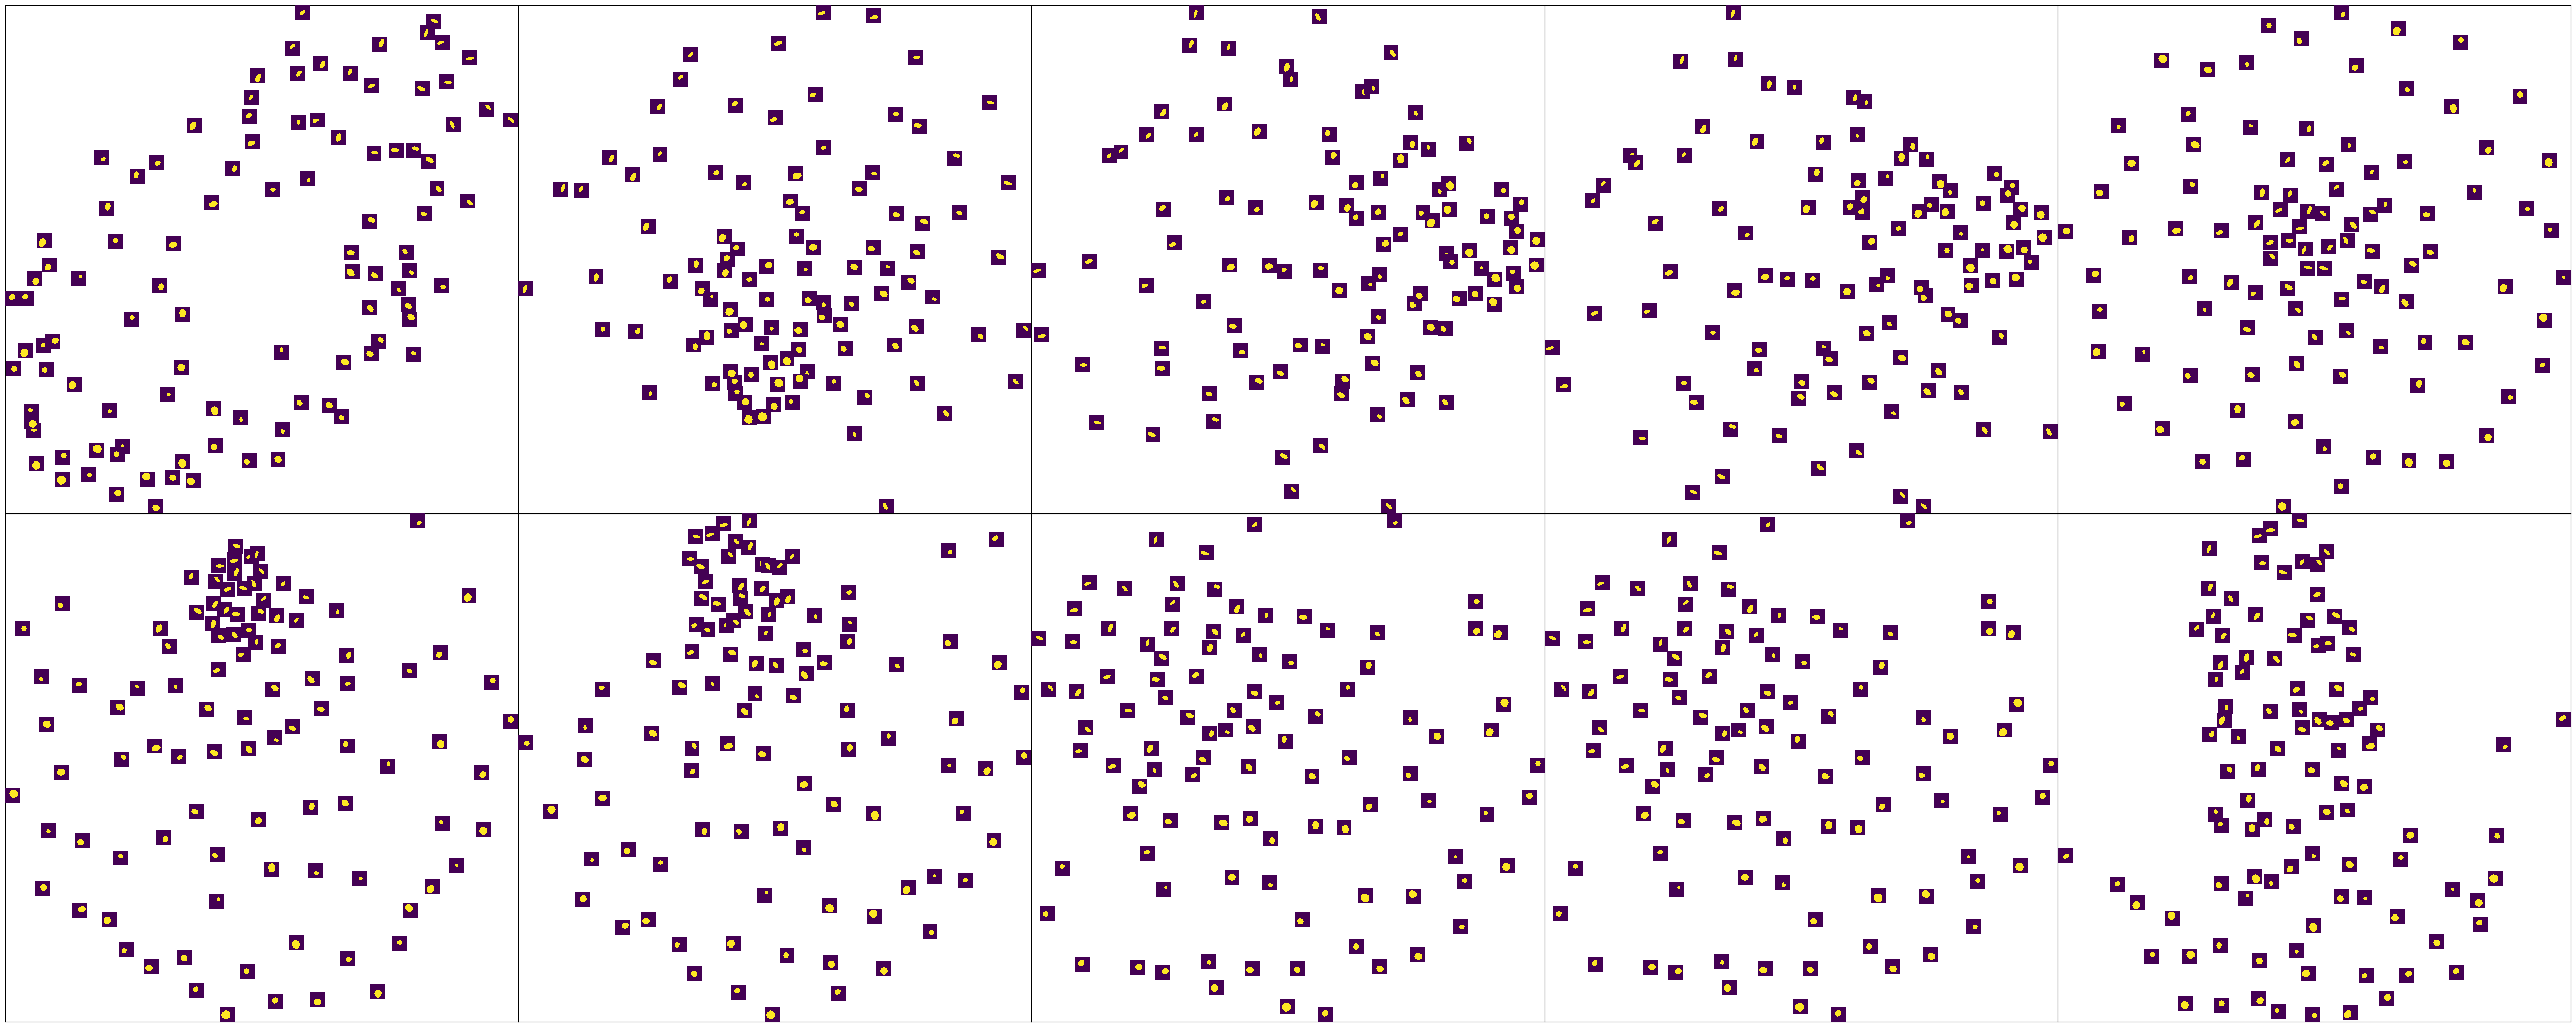

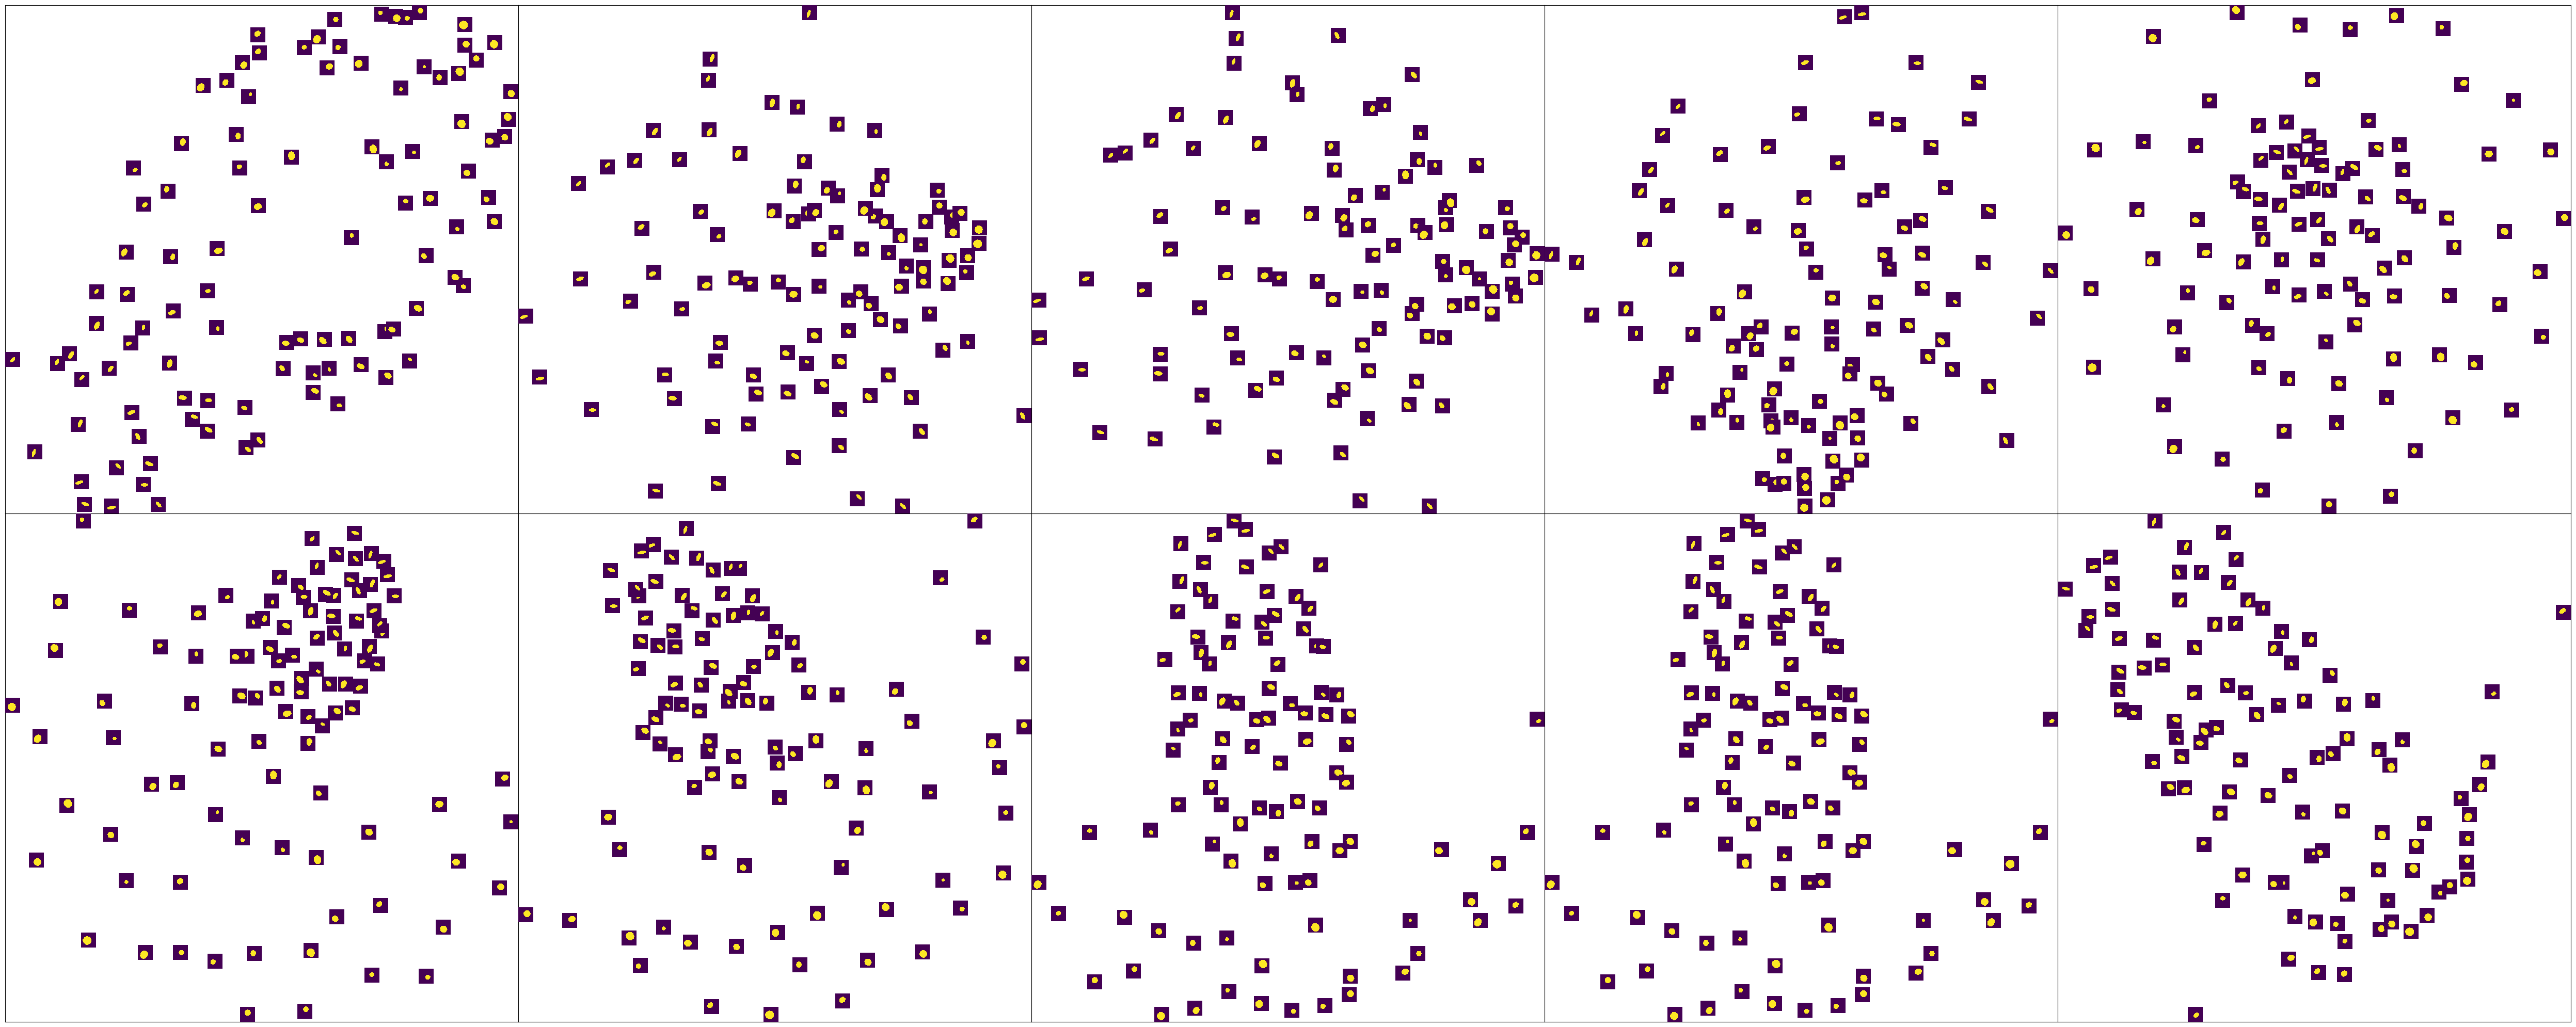

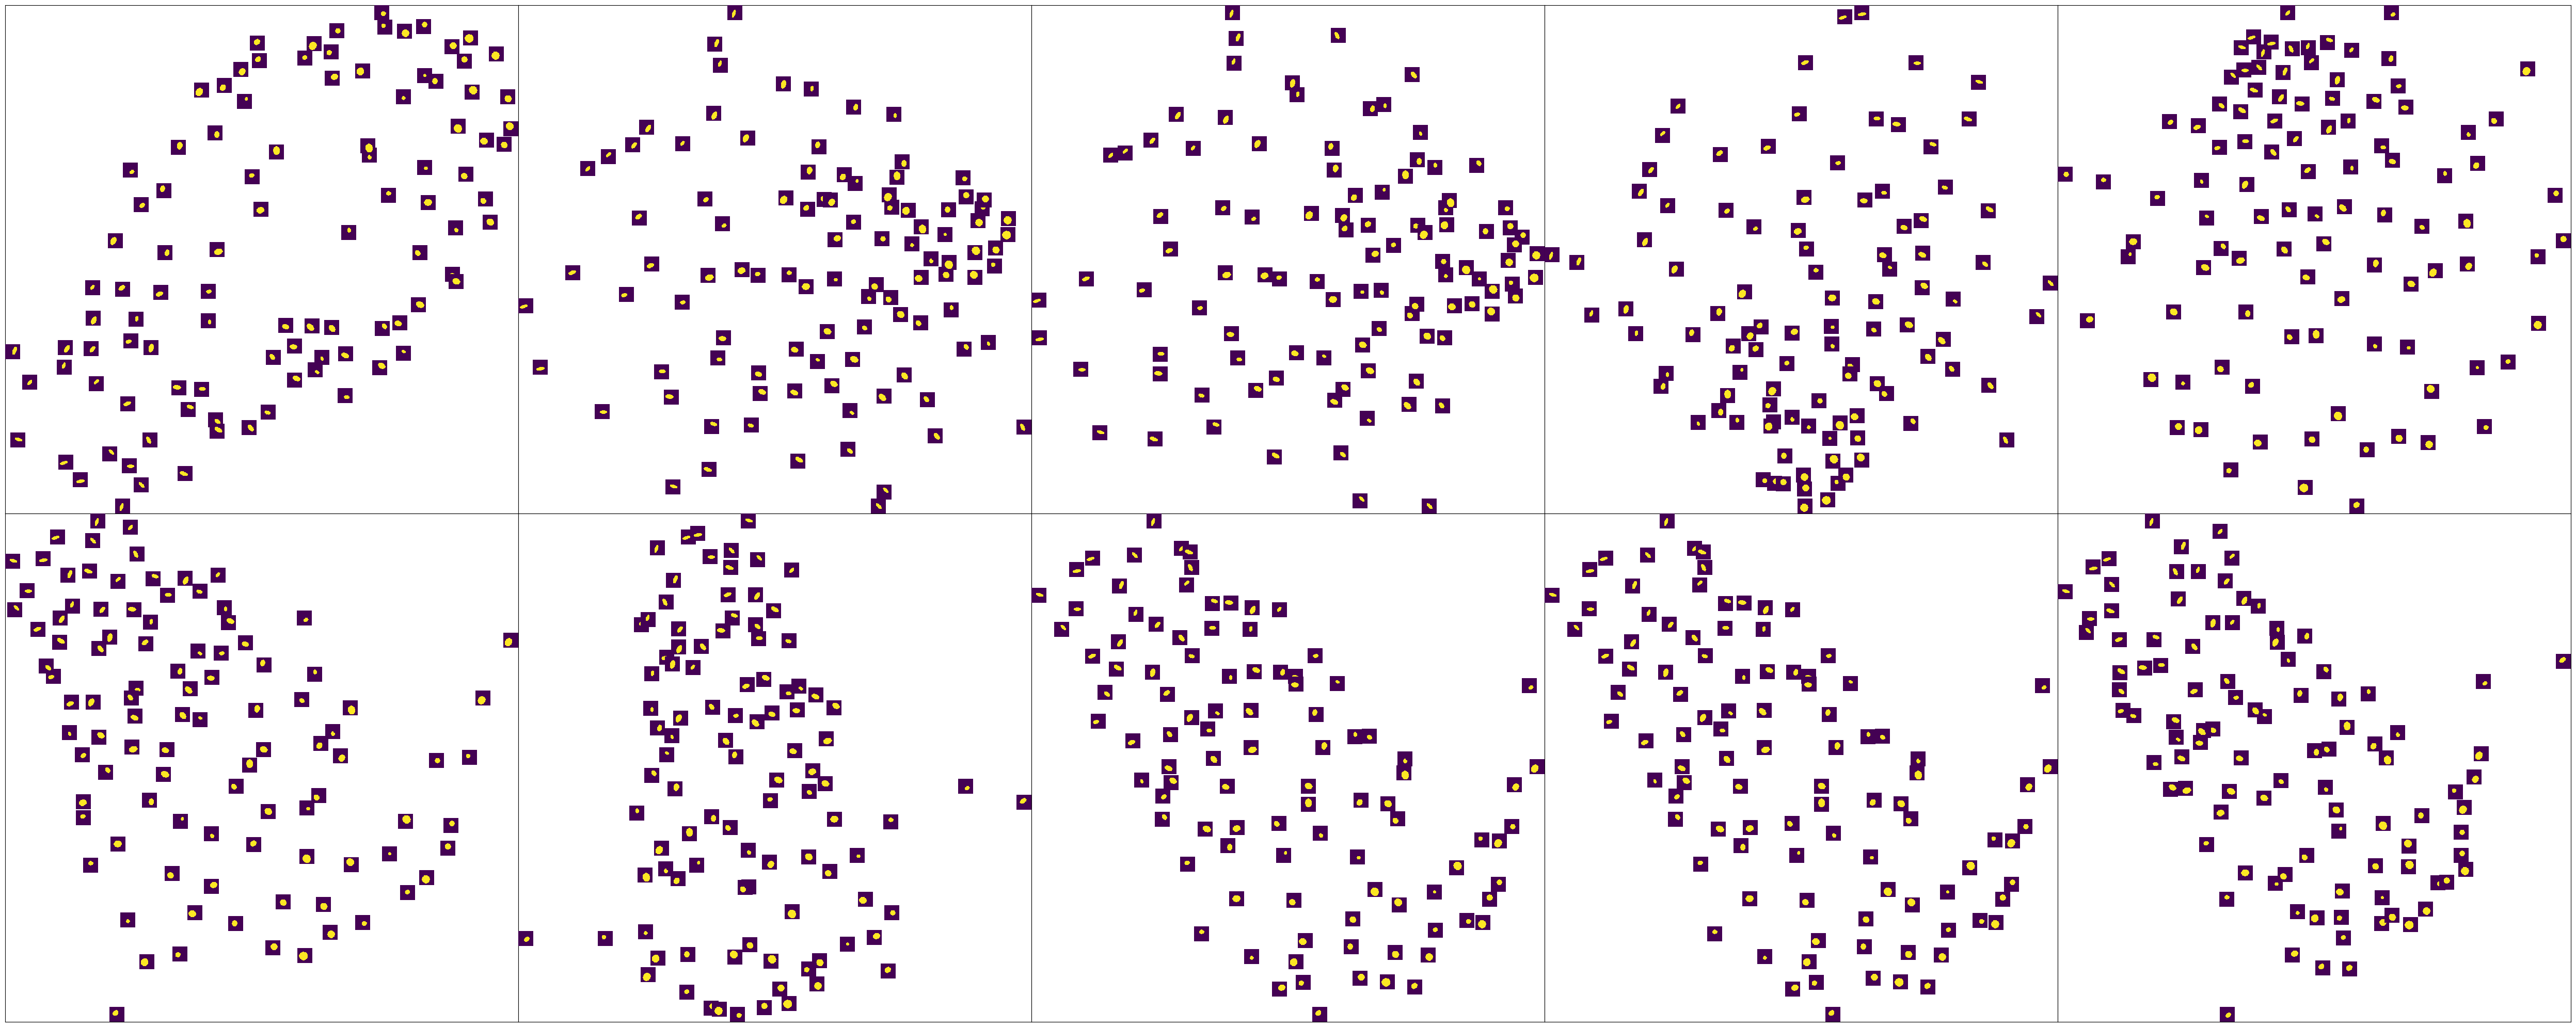

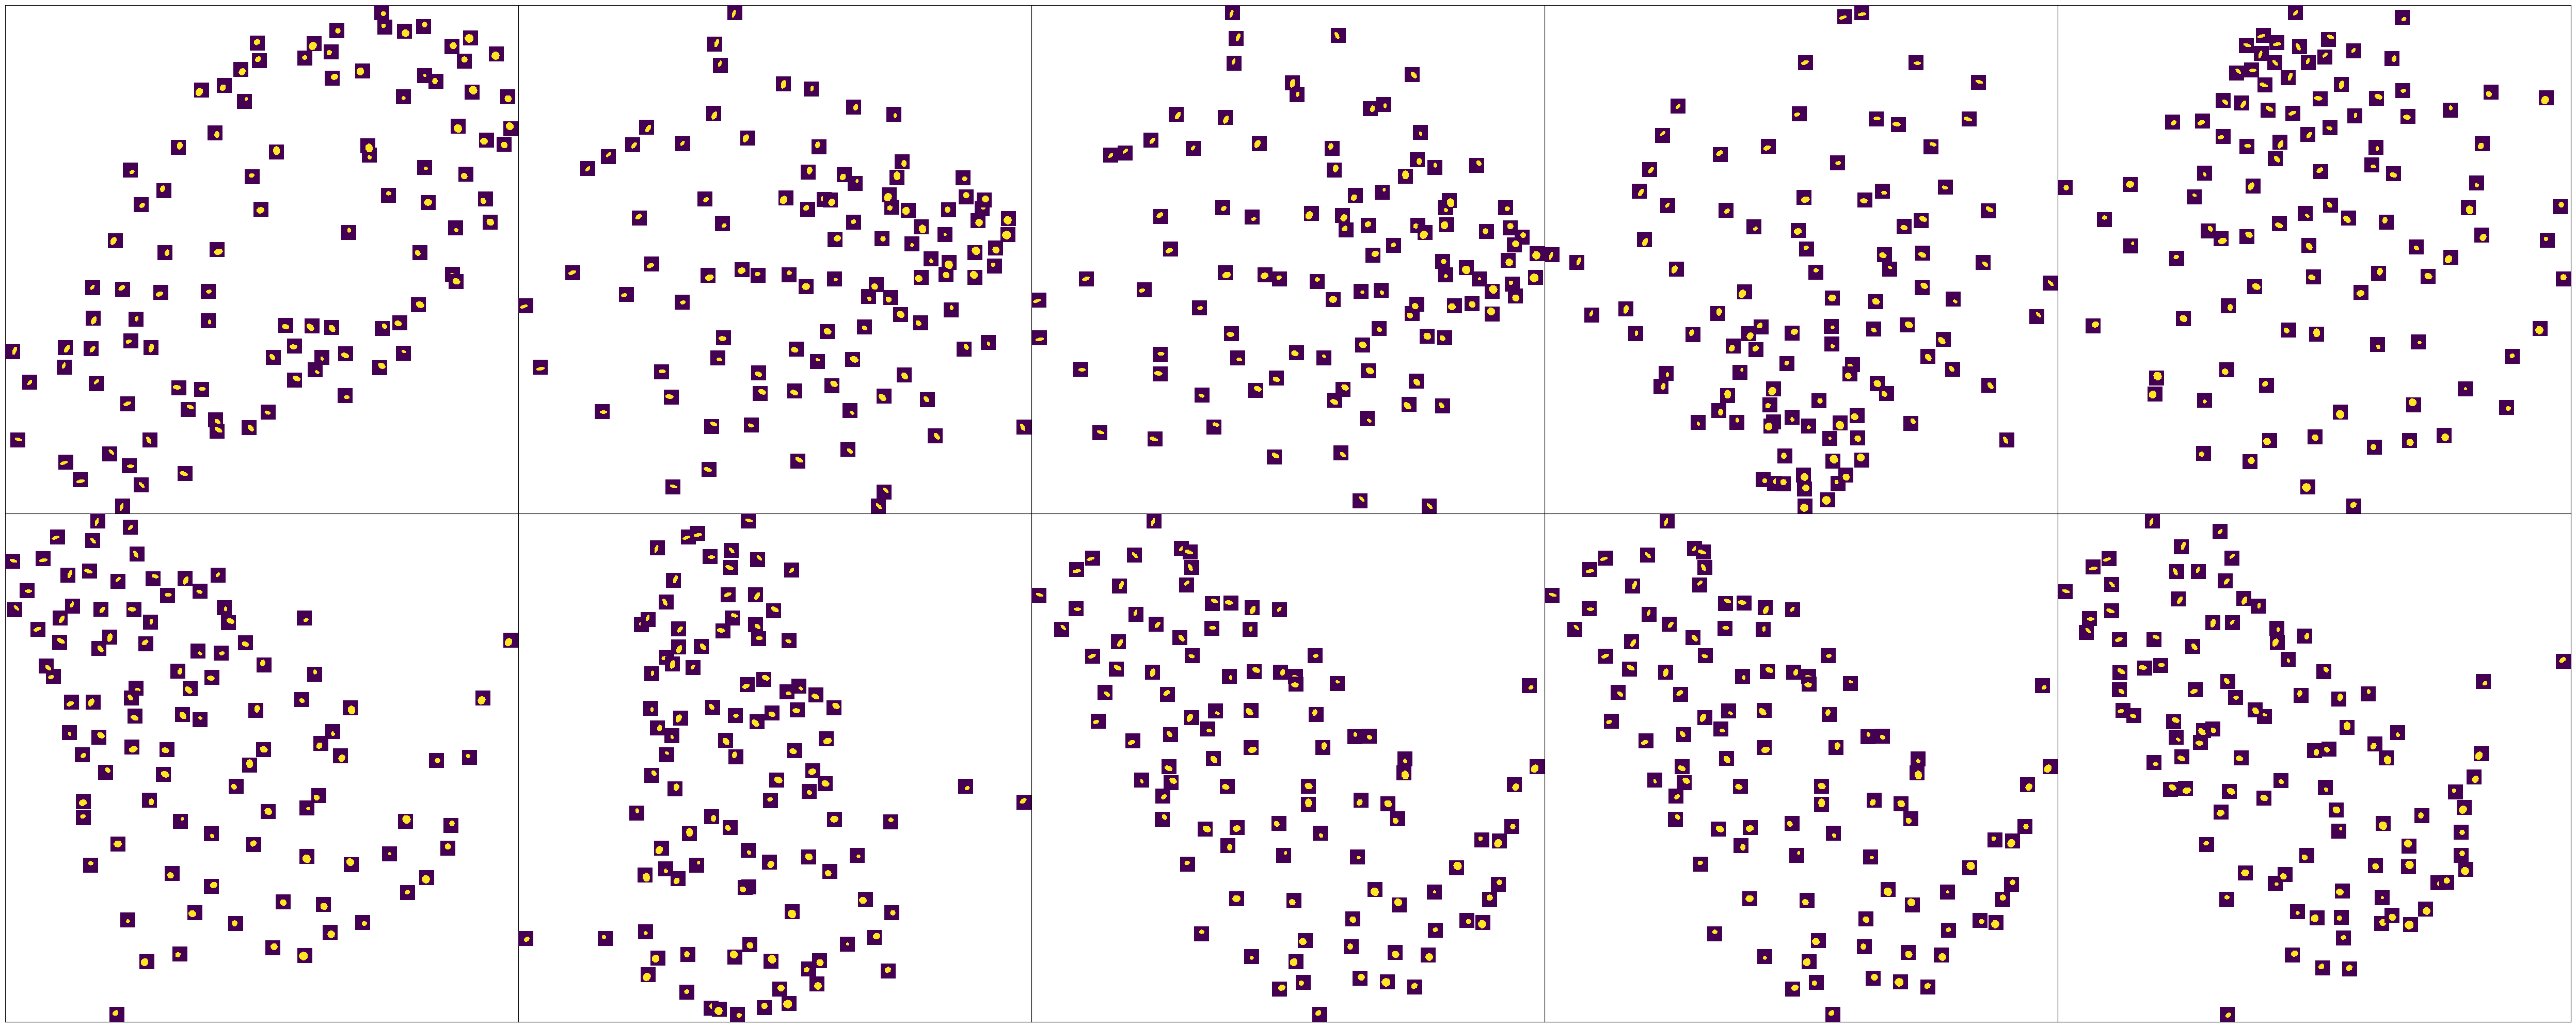

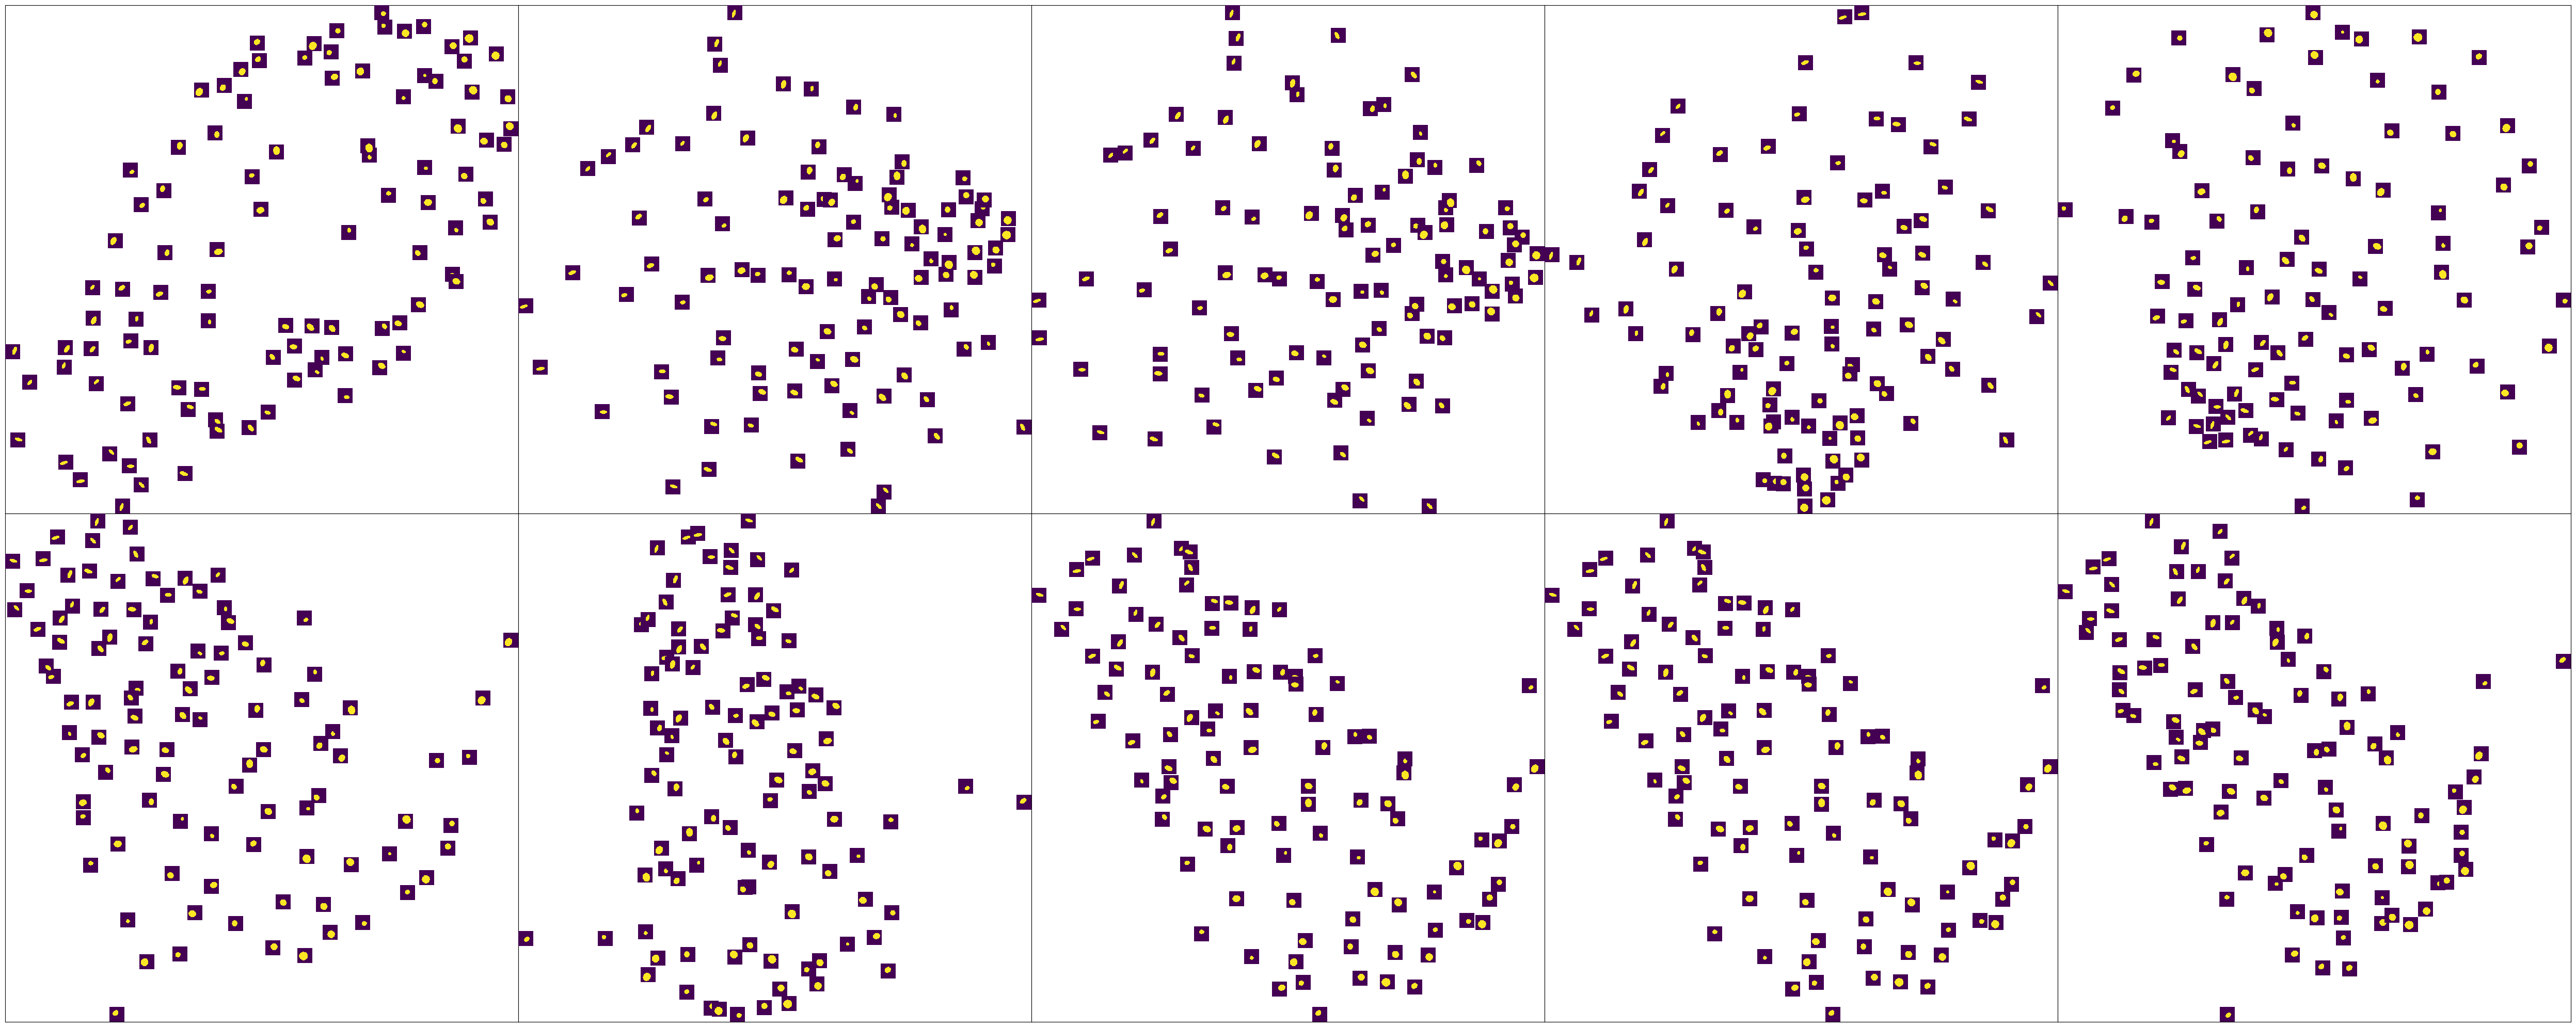

In [41]:
clf=PCA(n_components=2)
#plot ref spaces, associated LGW distances and MDS embeddings

for beta in [0.03,0.05,0.1,0.3,0.5]:
    Lambda=beta*LAMBDA_MAX
    fig, ax = plt.subplots(2,5, figsize = (50,20))
    result=torch.load(save_path+'/pgw_%0.3f.pt'%beta)
    pgw=result['dist']
    result=torch.load(save_path+'/lpgw_%0.3f.pt'%beta)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    for i in range(5):
        ax[0,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        ax[1,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=1,normalized_stress='auto')
    
        
        if i == 0:
            dist=pgw
        else:
            dist = lpgw_per_ref[i-1]
        dist=dist/dist.max()
        #plot
        #embedding1=smacof_mds(dist,2)
        #embedding1=clf.fit_transform(embedding1.copy())
        embedding1=mds.fit_transform(dist)
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])
    
        dist=lpgw_per_ref[i+4]
        dist=dist/dist.max()
        #embedding2=smacof_mds(dist,2)
        #embedding2=clf.fit_transform(embedding2.copy())
        embedding2=mds.fit_transform(dist)
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(save_path+"/lpgw_%0.3f.png"%beta)
    plt.show()

In [40]:
save_path

'results_nl_np_ns'

FileNotFoundError: [Errno 2] No such file or directory: 'results_total_mass/pgw_0.050.pt'

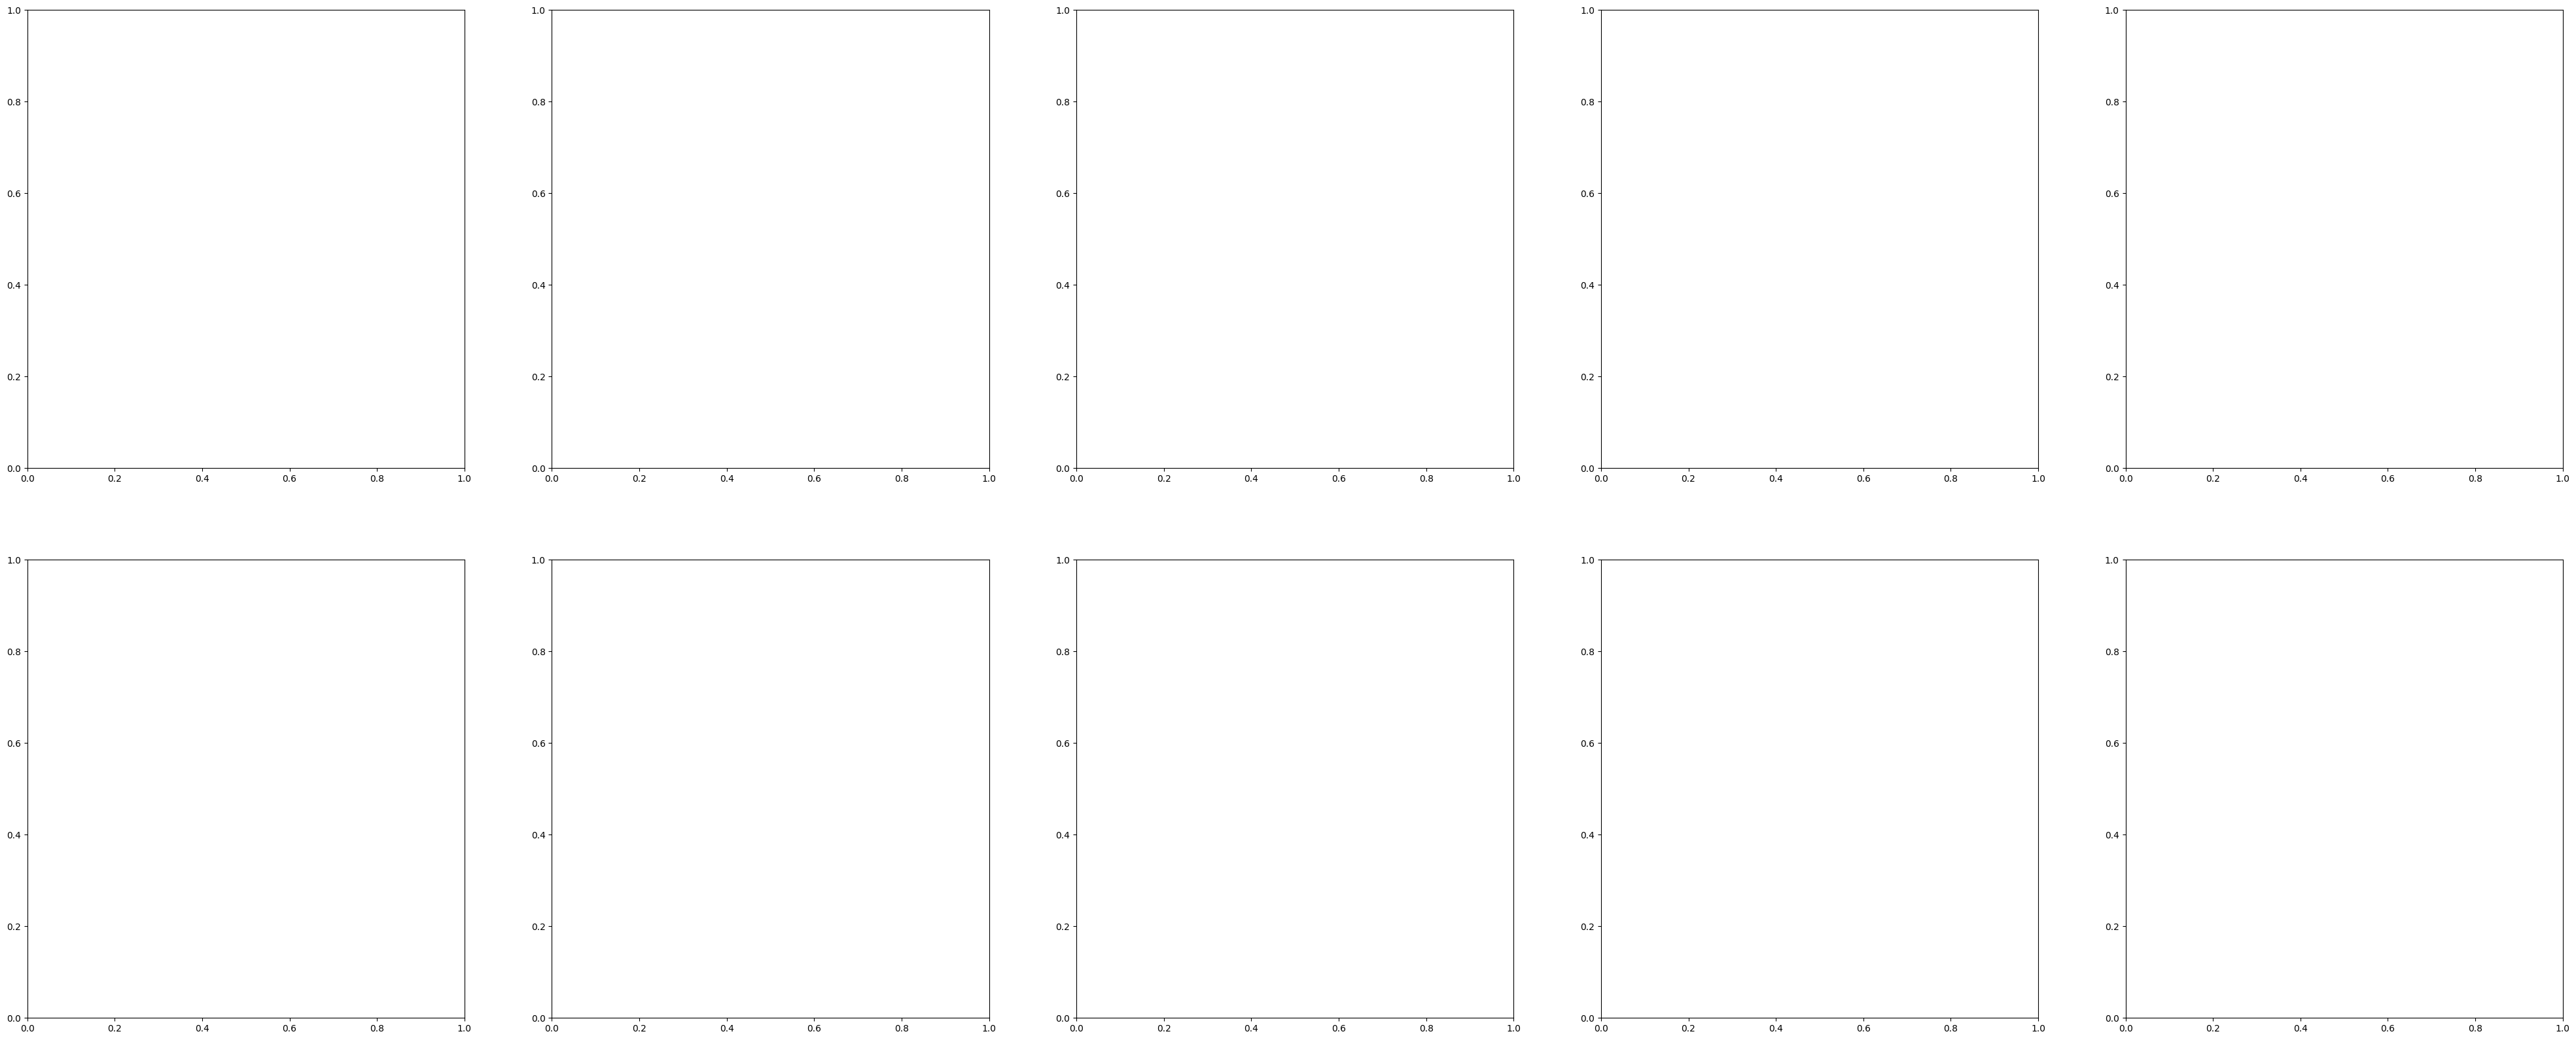

In [45]:
clf=PCA(n_components=2)
#plot ref spaces, associated LGW distances and MDS embeddings
imgs=torch.load('data/refs_imgs.pt')
for Lambda in Lambda_list:
    fig, ax = plt.subplots(2,5, figsize = (50,20))
    result=torch.load(save_path+'/pgw_%0.3f.pt'%Lambda)
    pgw=result['dist']
    result=torch.load(save_path+'/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    for i in range(5):
        ax[0,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        ax[1,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        #mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0,normalized_stress='auto')
    
       
        if i == 0:
            dist=pgw
        else:
            dist = lpgw_per_ref[i-1]
        #plot
        embedding1=smacof_mds(dist,2)
        embedding1=clf.fit_transform(embedding1.copy())
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])
        
        if i != 0:
            axins1 = inset_axes(ax[0, i], width="25%", height="25%", loc='lower left')
            axins1.axis('off')
            axins1.imshow(imgs[i-1])
    
        dist=lpgw_per_ref[i+4]
        embedding2=smacof_mds(dist,2)
        embedding2=clf.fit_transform(embedding2.copy())
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
        
        axins2 = inset_axes(ax[1, i], width="25%", height="25%", loc='lower left')  # Adjust the size and location
        axins2.axis('off')
        axins2.imshow(imgs[i+4])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(save_path+"/lpgw_mds_%0.3f.png"%Lambda,dpi=200)
    plt.close()

[[0.         0.05712914 0.11457666 ... 0.05980812 0.05183759 0.03929813]
 [0.05712914 0.         0.07623144 ... 0.03556364 0.03921182 0.04698063]
 [0.11457666 0.07623144 0.         ... 0.06408419 0.07948969 0.1045204 ]
 ...
 [0.05980812 0.03556364 0.06408419 ... 0.         0.02479917 0.04439203]
 [0.05183759 0.03921182 0.07948969 ... 0.02479917 0.         0.03170485]
 [0.03929813 0.04698063 0.1045204  ... 0.04439203 0.03170485 0.        ]]


/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


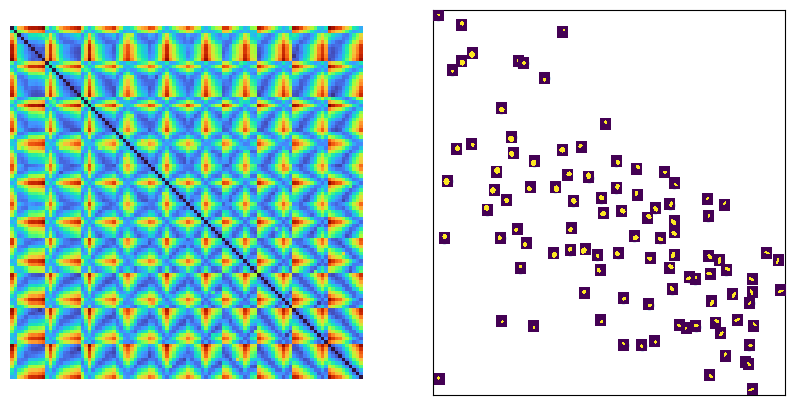

In [24]:

# Plot for gw  

result=torch.load('results_save/gw.pt')
gw=result['dist']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gw,cmap = "turbo")
ax[0].axis("off")

print(gw)
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(gw)
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()
    


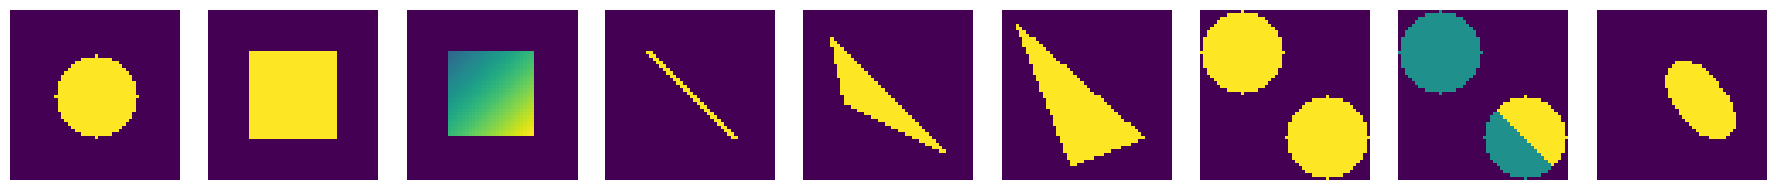

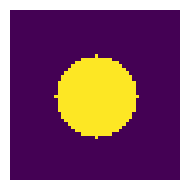

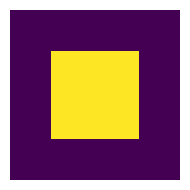

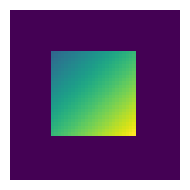

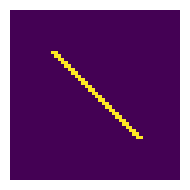

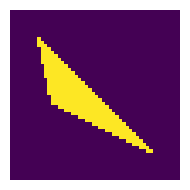

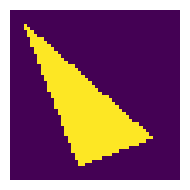

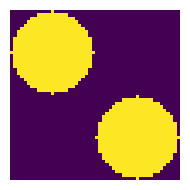

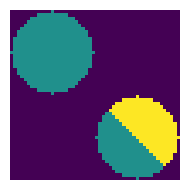

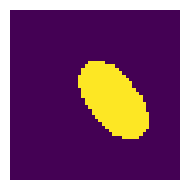

In [21]:
refs = []
imgs = []

fig,ax = plt.subplots(1,9,figsize=(18,2))
for x in ax.ravel():
    x.axis("off")

circ = cv2.circle(np.zeros((x_len,y_len)),(x_len//2,y_len//2),x_len//4,color=1,thickness=-1)
circ /= np.sum(circ)
ax[0].imshow(circ)
imgs.append(circ)
refs.append(mm_space_from_img(circ))

rec = cv2.rectangle(np.zeros((x_len,y_len)),(x_len//4,x_len//4),(3*x_len//4,3*x_len//4),color=1,thickness=-1)
rec /= np.sum(rec)
ax[1].imshow(rec)
imgs.append(rec)
refs.append(mm_space_from_img(rec))

rec2 = np.zeros((x_len,y_len))
for i in range(x_len//4,3*x_len//4):
    for j in range(x_len//4,3*x_len//4):
        rec2[i,j] = i+j
rec2 /= np.sum(rec2)
ax[2].imshow(rec2)
imgs.append(rec2)
refs.append(mm_space_from_img(rec2))

tmp_pts = [(x_len//4,y_len//4),(x_len//4 + 1,y_len//4),(3*x_len//4 + 1,3*y_len//4),(3*x_len//4,3*y_len//4)]
line = cv2.fillPoly(np.zeros((x_len,y_len)), np.array([tmp_pts]), 1)
line /= np.sum(line)
ax[3].imshow(line)
imgs.append(line)
refs.append(mm_space_from_img(line))

tmp_pts = [(x_len//4 - 4,y_len//4 - 4),(x_len//4,y_len//2+2),(3*x_len//4+4,3*y_len//4+4)]
tri = cv2.fillPoly(np.zeros((x_len,y_len)), np.array([tmp_pts]), 1)
tri /= np.sum(tri)
ax[4].imshow(tri)
imgs.append(tri)
refs.append(mm_space_from_img(tri))

tmp_pts = [(x_len//4 - 8,y_len//4 - 8),(x_len//4+8,y_len//2+20),(3*x_len//4+4,3*y_len//4)]
tri2 = cv2.fillPoly(np.zeros((x_len,y_len)), np.array([tmp_pts]), 1)
tri2 /= np.sum(tri2)
ax[5].imshow(tri2)
imgs.append(tri2)
refs.append(mm_space_from_img(tri2))

circ2 = cv2.circle(np.zeros((x_len,y_len)),(x_len//4,y_len//4),x_len//4,color=1,thickness=-1) + cv2.circle(np.zeros((x_len,y_len)),(3*x_len//4,3*y_len//4),x_len//4,color=1,thickness=-1)
circ2 /= np.sum(circ2)
ax[6].imshow(circ2)
imgs.append(circ2)
refs.append(mm_space_from_img(circ2))

circ3 = np.copy(circ2)
for i in range(25,50):
    circ3[i,i:] *= 2
circ3 /= np.sum(circ3)
ax[7].imshow(circ3)
imgs.append(circ3)
refs.append(mm_space_from_img(circ3))

m_ell = ells_flat[28]
m_ell /= np.sum(m_ell)
ax[8].imshow(m_ell)
imgs.append(m_ell)
refs.append(mm_space_from_img(m_ell))

torch.save(refs,'results/refs.pt')
torch.save(imgs,'results/imgs.pt')
plt.tight_layout()
plt.savefig('results/ellipse_reference.png', dpi=200, bbox_inches='tight')
plt.show()


for i,(ref,img) in enumerate(zip(refs,imgs)):
    j=i+1
    supp,M,height=ref
    height=np.ones(supp.shape[0])
    supp=normalize(supp)
    M/=M.max()
    refs[i]=(supp,M,height)
    fig,ax = plt.subplots(1,1,figsize=(2,2))
    ax.axis("off")
    ax.imshow(img)
    plt.savefig('results/S_%i.png'%j, dpi=200, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [12]:
#Compute LGW distances for all reference measures
refs=torch.load('results/refs.pt')
Gs_per_ref = []
dist_per_ref = []
times_per_ref = []
idx = 0
for k in range(len(refs)):
    supp,M,height = refs[k]
    Gs = []
    BPs = []
    st = time.time()
    height1=height/height.sum()
    n=height1.shape[0]
    for i in range(N):
        height2=heights[i]/heights[i].sum()
        #Compute Wasserstein coupling
        M_ot = ot.dist(supp,posns[i])
        G0 = ot.emd(height1,height2,M_ot)
        
        #Compute GW coupling with initial coupling set to Wasserstein coupling G0
        #constC, hC1, hC2 = init_matrix(M, Ms[i], height, heights[i], "square_loss")
        
        G =gromov_wasserstein(M, Ms[i], height1, height2, G0=G0,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=True) 
        #cg(height, heights[i], 0, 1, f, df, G0, armijo=False, C1=M, C2=Ms[i], constC=constC)
        Gs.append(G)
        
        #barycentric projection of GW coupling P
        BP = (np.divide(G.T,height1).T).dot(posns[i])
        BPs.append(BP)
    dist = np.zeros((N,N))
    for i in range(N):
        for j in range(i + 1, N):
            C1_tilde=cost_matrix_d(BPs[i],BPs[i])
            C2_tilde=cost_matrix_d(BPs[j],BPs[j])
            dist[i, j] = np.sqrt(LGW_dist(C1_tilde,C2_tilde,height1))

    dist += dist.T
    et = time.time()
    print("Time for LGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")
    
    times_per_ref.append(et-st)
    Gs_per_ref.append(Gs)
    dist_per_ref.append(dist)

result={}
result['dist_per_ref'],result['times_per_ref']=dist_per_ref,times_per_ref
torch.save(result,'results/lgw.pt')

Time for LGW with ref space 0: 1.16 min
Time for LGW with ref space 1: 4.21 min
Time for LGW with ref space 2: 3.29 min
Time for LGW with ref space 3: 0.09 min
Time for LGW with ref space 4: 0.54 min
Time for LGW with ref space 5: 1.61 min
Time for LGW with ref space 6: 2.5 min
Time for LGW with ref space 7: 2.66 min
Time for LGW with ref space 8: 0.77 min


In [152]:
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    "" This code is imported from PythonOT: Gromov-Wasserstein Barycenter example 
    https://pythonot.github.io/auto_examples/gromov/plot_gromov_barycenter.html
    
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

   #rng = np.random.RandomState(seed=3)
    seed=0
    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        normalized_stress='auto',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress='auto',
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos
def plot_2d_shape_embedding(data, embedding, min_dist, figsize, cutoff=5, font_size=16, labels=None, save_path=None, col=None, show_numbers=False, padwidth=2, return_img=False, axex=None):
    # Cut outliers
    n_pts = data.shape[0]
    n_dims = data.shape[1]
    low = [np.percentile(embedding[:, 0], q=cutoff), np.percentile(embedding[:, 1], q=cutoff)]
    high = [np.percentile(embedding[:, 0], q=100 - cutoff), np.percentile(embedding[:, 1], q=100 - cutoff)]
    cut_inds = np.arange(n_pts)[(embedding[:, 0] >= low[0]) * (embedding[:, 0] <= high[0])
                                * (embedding[:, 1] >= low[1]) * (embedding[:, 1] <= high[1])]

    data = data[cut_inds, :]
    embedding = embedding[cut_inds, :]

    # Visualize
    fig_x, fig_y = figsize
    fig_ratio = fig_x / fig_y
    #fig = plt.figure(figsize=(fig_x, fig_y))
    #ax = fig.add_subplot(111)

    # Plot images
    img_scale = 0.03
    pixels_per_dimension = int(np.sqrt(n_dims))

    x_size = (max(embedding[:, 0]) - min(embedding[:, 0])) * img_scale
    y_size = (max(embedding[:, 1]) - min(embedding[:, 1])) * img_scale * fig_ratio
    shown_images = np.array([[100., 100.]])

    if labels is not None:
        NUM_COLORS = len(np.unique(labels))
        cm = plt.get_cmap('gist_rainbow')
        unique_labels = np.unique(labels)

    for i in range(n_pts):
        #         dist = np.sqrt(np.sum((embedding[i] - shown_images) ** 2, axis=1))
        # don't show points that are too close
        #         if np.min(dist) < min_dist:
        #             continue
        #         shown_images = np.r_[shown_images, [embedding[i]]]
        x0 = embedding[i, 0] - (x_size / 2.)
        y0 = embedding[i, 1] - (y_size / 2.)
        x1 = embedding[i, 0] + (x_size / 2.)
        y1 = embedding[i, 1] + (y_size / 2.)
        if col is None:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension)
        else:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension,3)
        #print(np.shape(data[i,:]))
        if labels is not None:
            j = list(unique_labels).index(labels[i])
            col_lab = cm(1.*j/NUM_COLORS)[:3]
            img = np.pad(img.astype(float), (padwidth,padwidth), "constant", constant_values=-1)
            img = np.array([np.array([[x/255,x/255,x/255] if x != -1 else col_lab for x in tmp]) for tmp in img])
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1),cmap="viridiris")
        else:
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
        if show_numbers:
            plt.text(x1, y1, str(i), color="black", fontdict={"fontsize":10,"fontweight":'bold',"ha":"left", "va":"baseline"})


    # scatter plot points
    axex.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=150, alpha=0.5)
    axex.tick_params(axis='both', which='major', labelsize=font_size - 4)

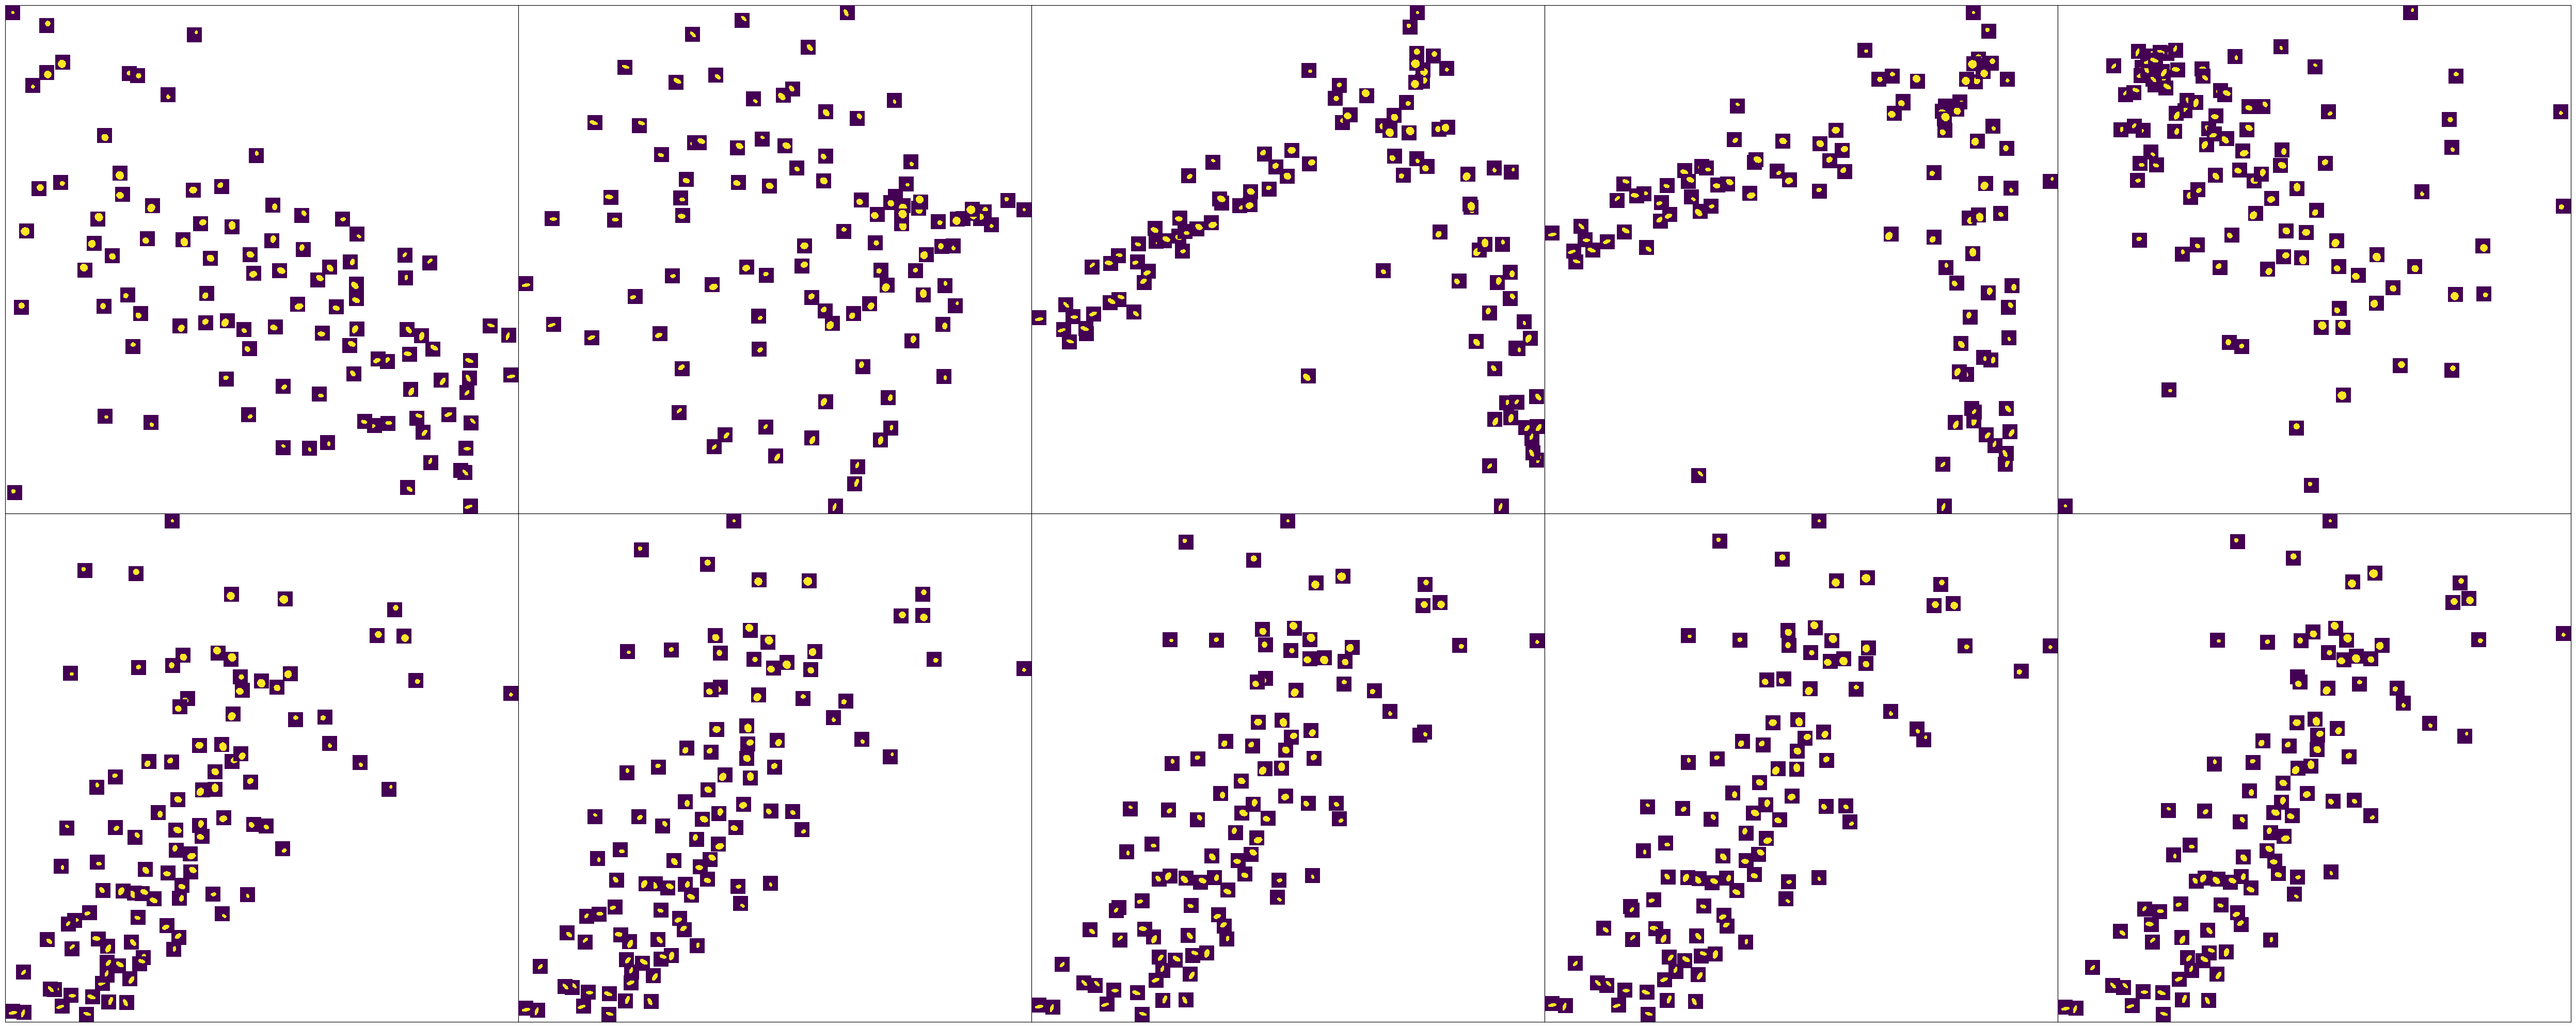

In [162]:
clf=PCA(n_components=2)
#plot ref spaces, associated LGW distances and MDS embeddings
fig, ax = plt.subplots(2,5, figsize = (50,20))
result=torch.load('results/gw.pt')
gw=result['dist']
result=torch.load('results/lgw.pt')
lgw_per_ref=result['dist_per_ref']
times_per_ref=result['times_per_ref']
for i in range(5):
    ax[0,i].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax[1,i].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0,normalized_stress='auto')

   
    if i == 0:
        dist=gw
    else:
        dist = lgw_per_ref[i-1]
    #plot
    embedding1=mds.fit_transform(dist)
    #embedding1=smacof_mds(dist,2)
    #embedding1=clf.fit_transform(embedding1.copy())
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])

    dist=lgw_per_ref[i+4]
    
    #embedding2=smacof_mds(dist,2)
    #embedding2=clf.fit_transform(embedding2.copy())
    embedding2=mds.fit_transform(dist)
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("results/lgw.png")
plt.show()

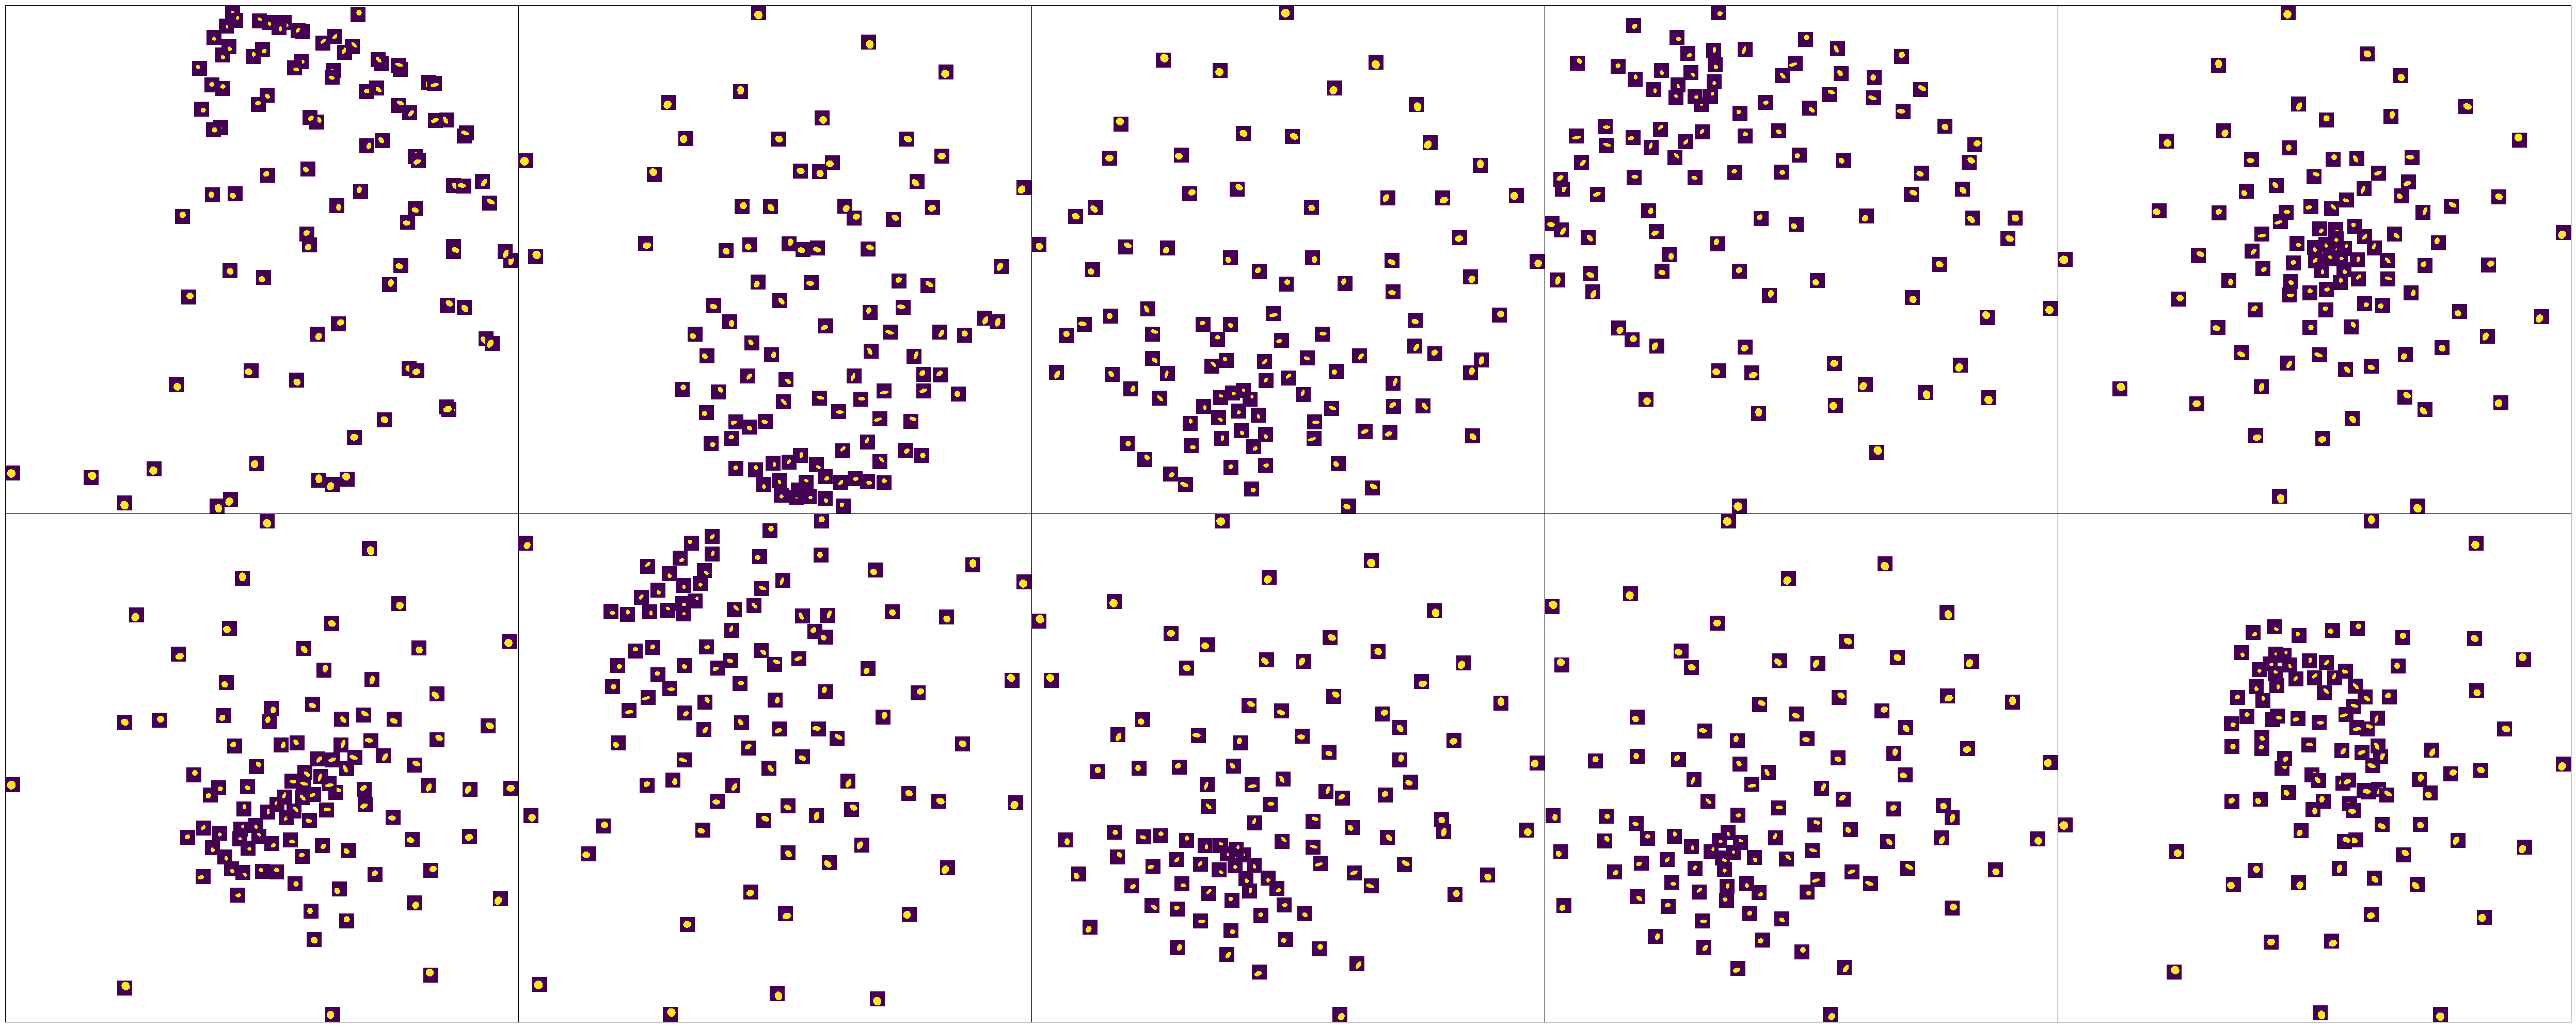

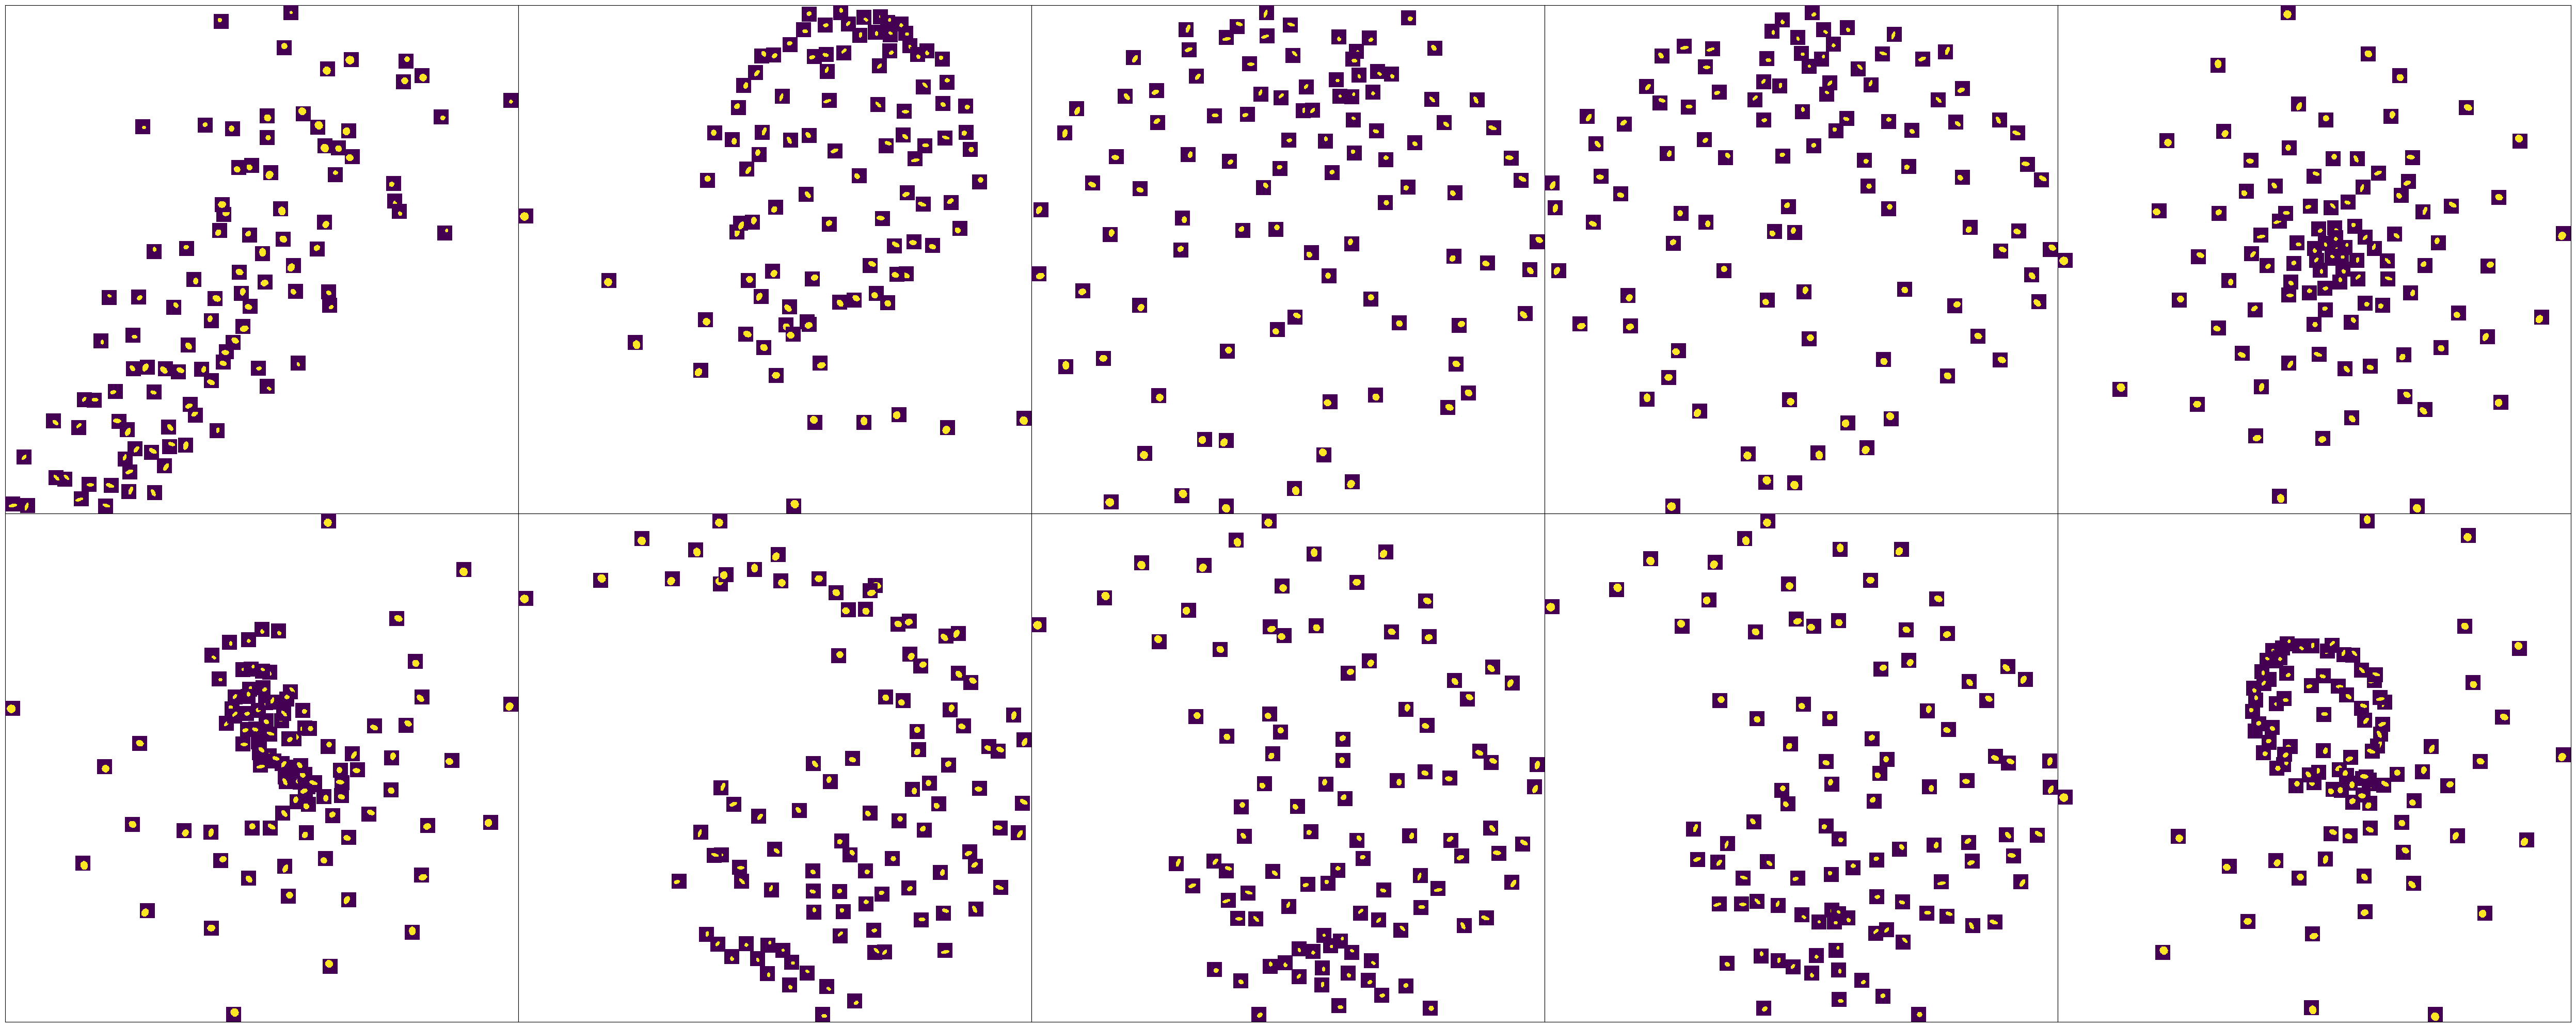

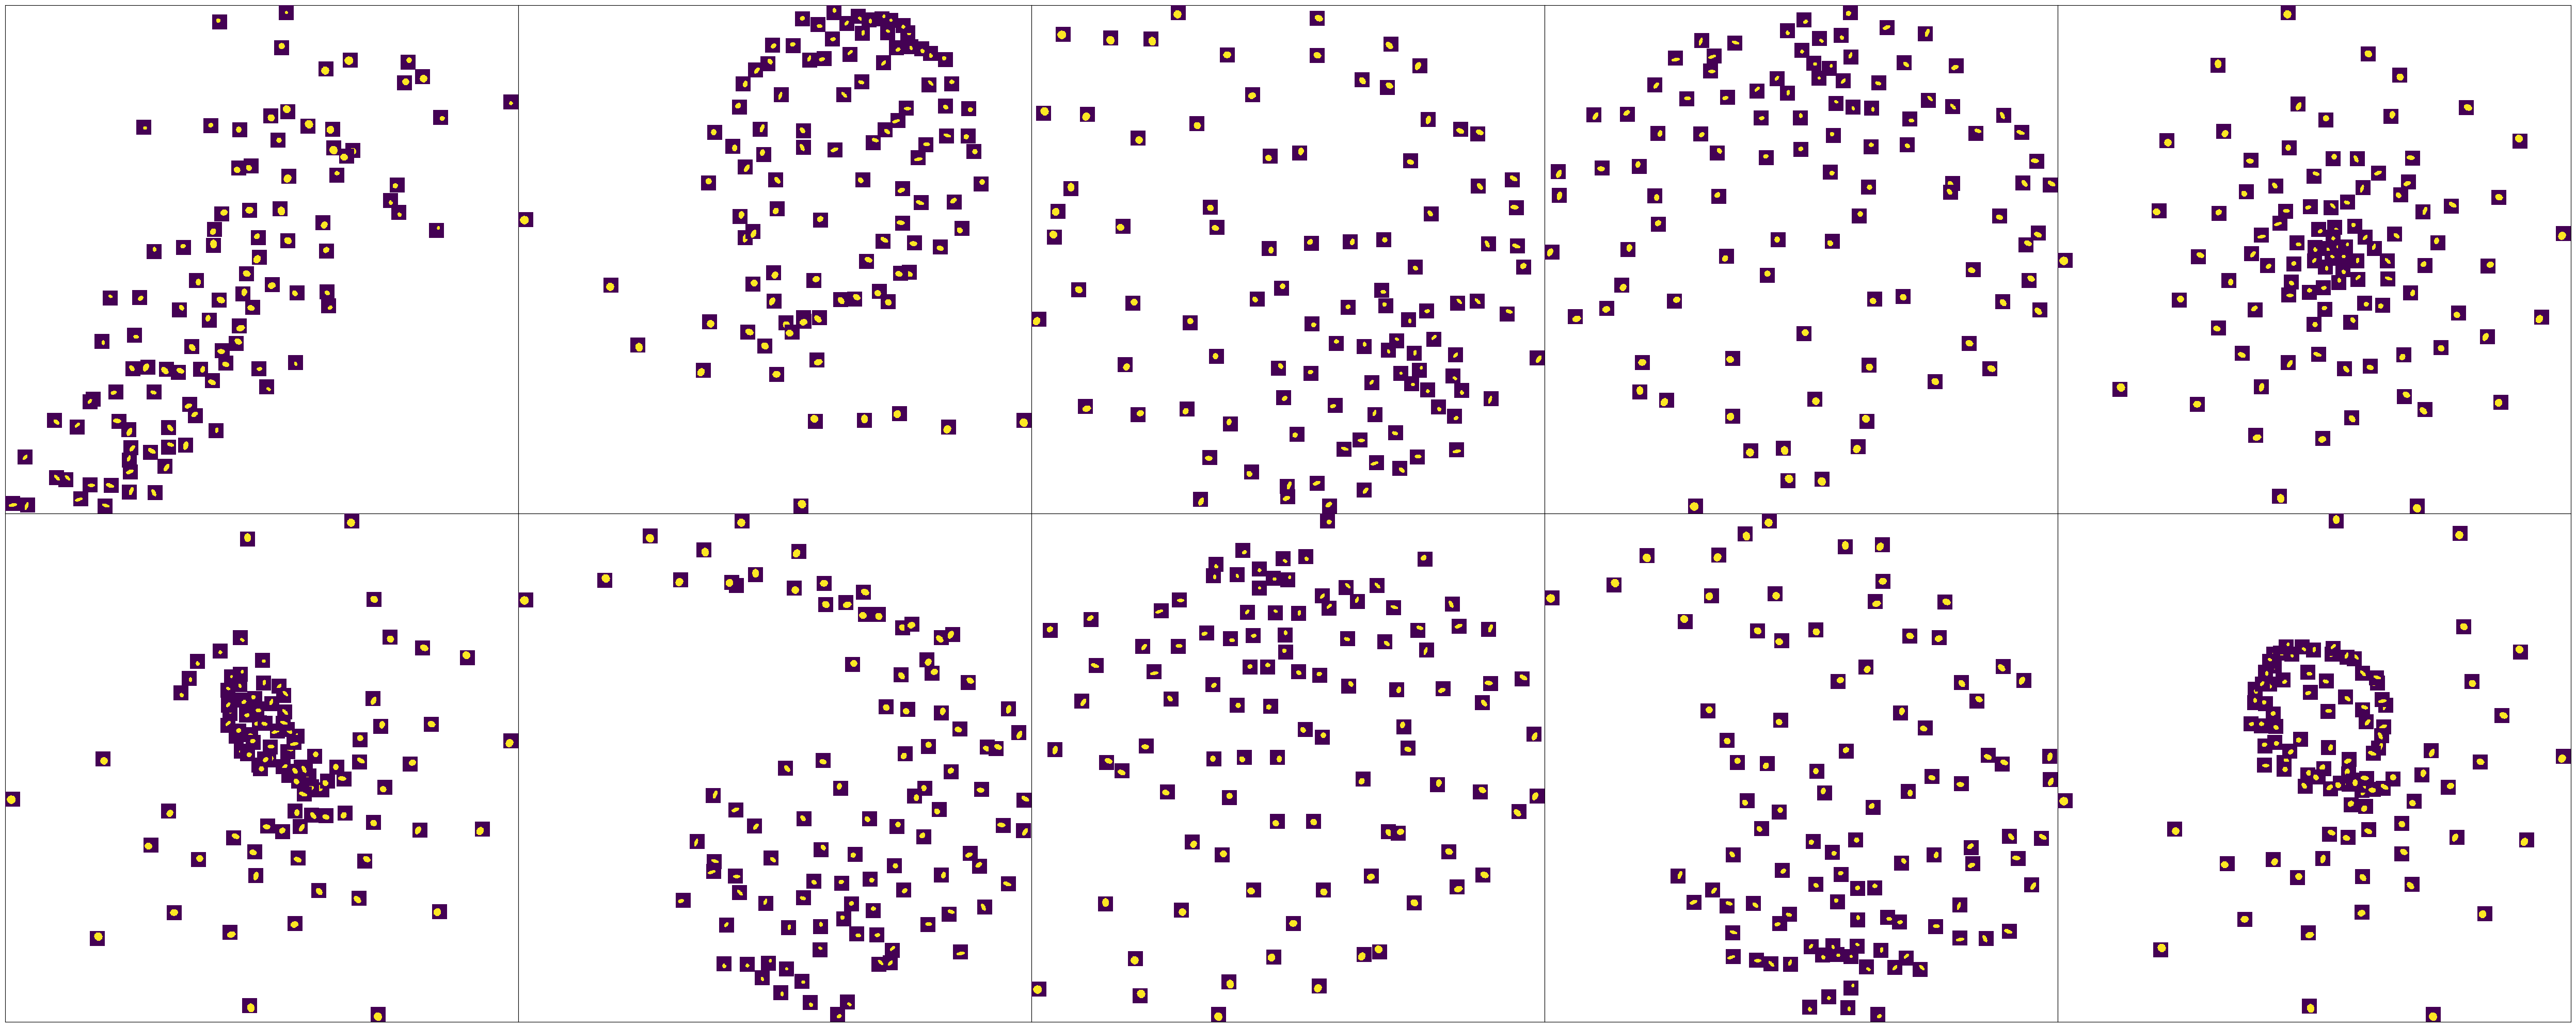

KeyboardInterrupt: 

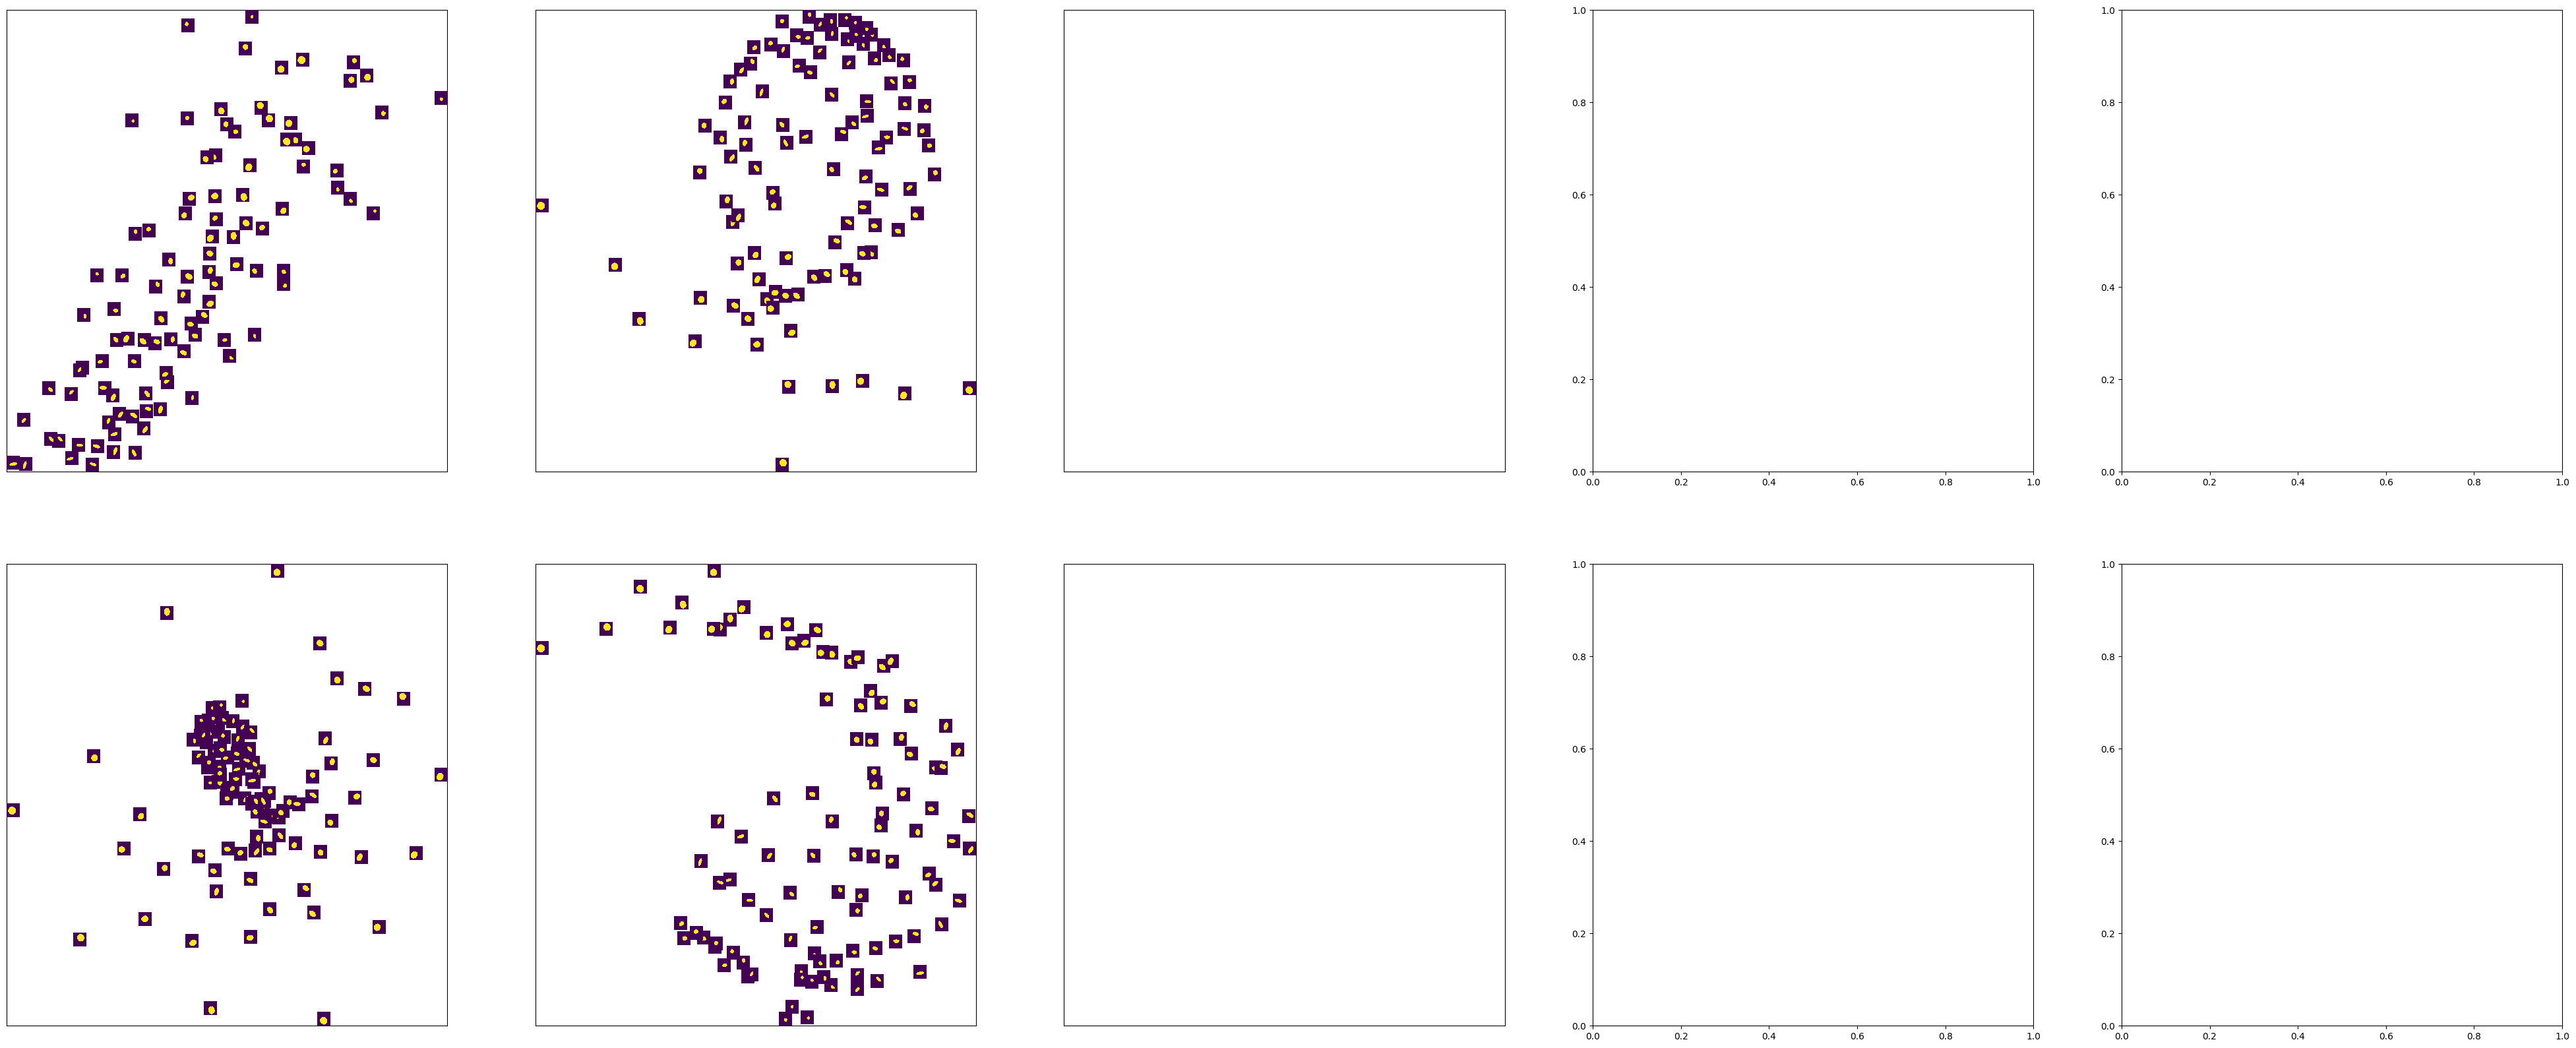

In [56]:
print("        MRE       PCC      time in mins     no. of points")
for i in range(9):
    m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
    m_lgw = np.ma.masked_equal(lgw_per_ref[i], 0.0, copy=False)
    print("Ref " + str(i+1) + ":  " 
          + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)) 
          + "    " 
          + str(np.round(np.corrcoef(gw.flatten(),m_lgw.flatten())[1,0],4))
          + "    "
          + str(np.round((times_per_ref[i])/60,2))
          + "             "
          + str(np.sum(imgs[i] != 0)))

        MRE       PCC      time in mins     no. of points
Ref 1:  0.9296    0.5348    1.16             441
Ref 2:  0.8262    0.5462    4.21             676
Ref 3:  0.7996    0.5742    3.29             625
Ref 4:  0.3109    0.835    0.09             52
Ref 5:  0.0908    0.9889    0.54             289
Ref 6:  0.0671    0.9955    1.61             545
Ref 7:  0.0285    0.9977    2.5             882
Ref 8:  0.0355    0.9944    2.66             882
Ref 9:  0.0394    0.9976    0.77             317


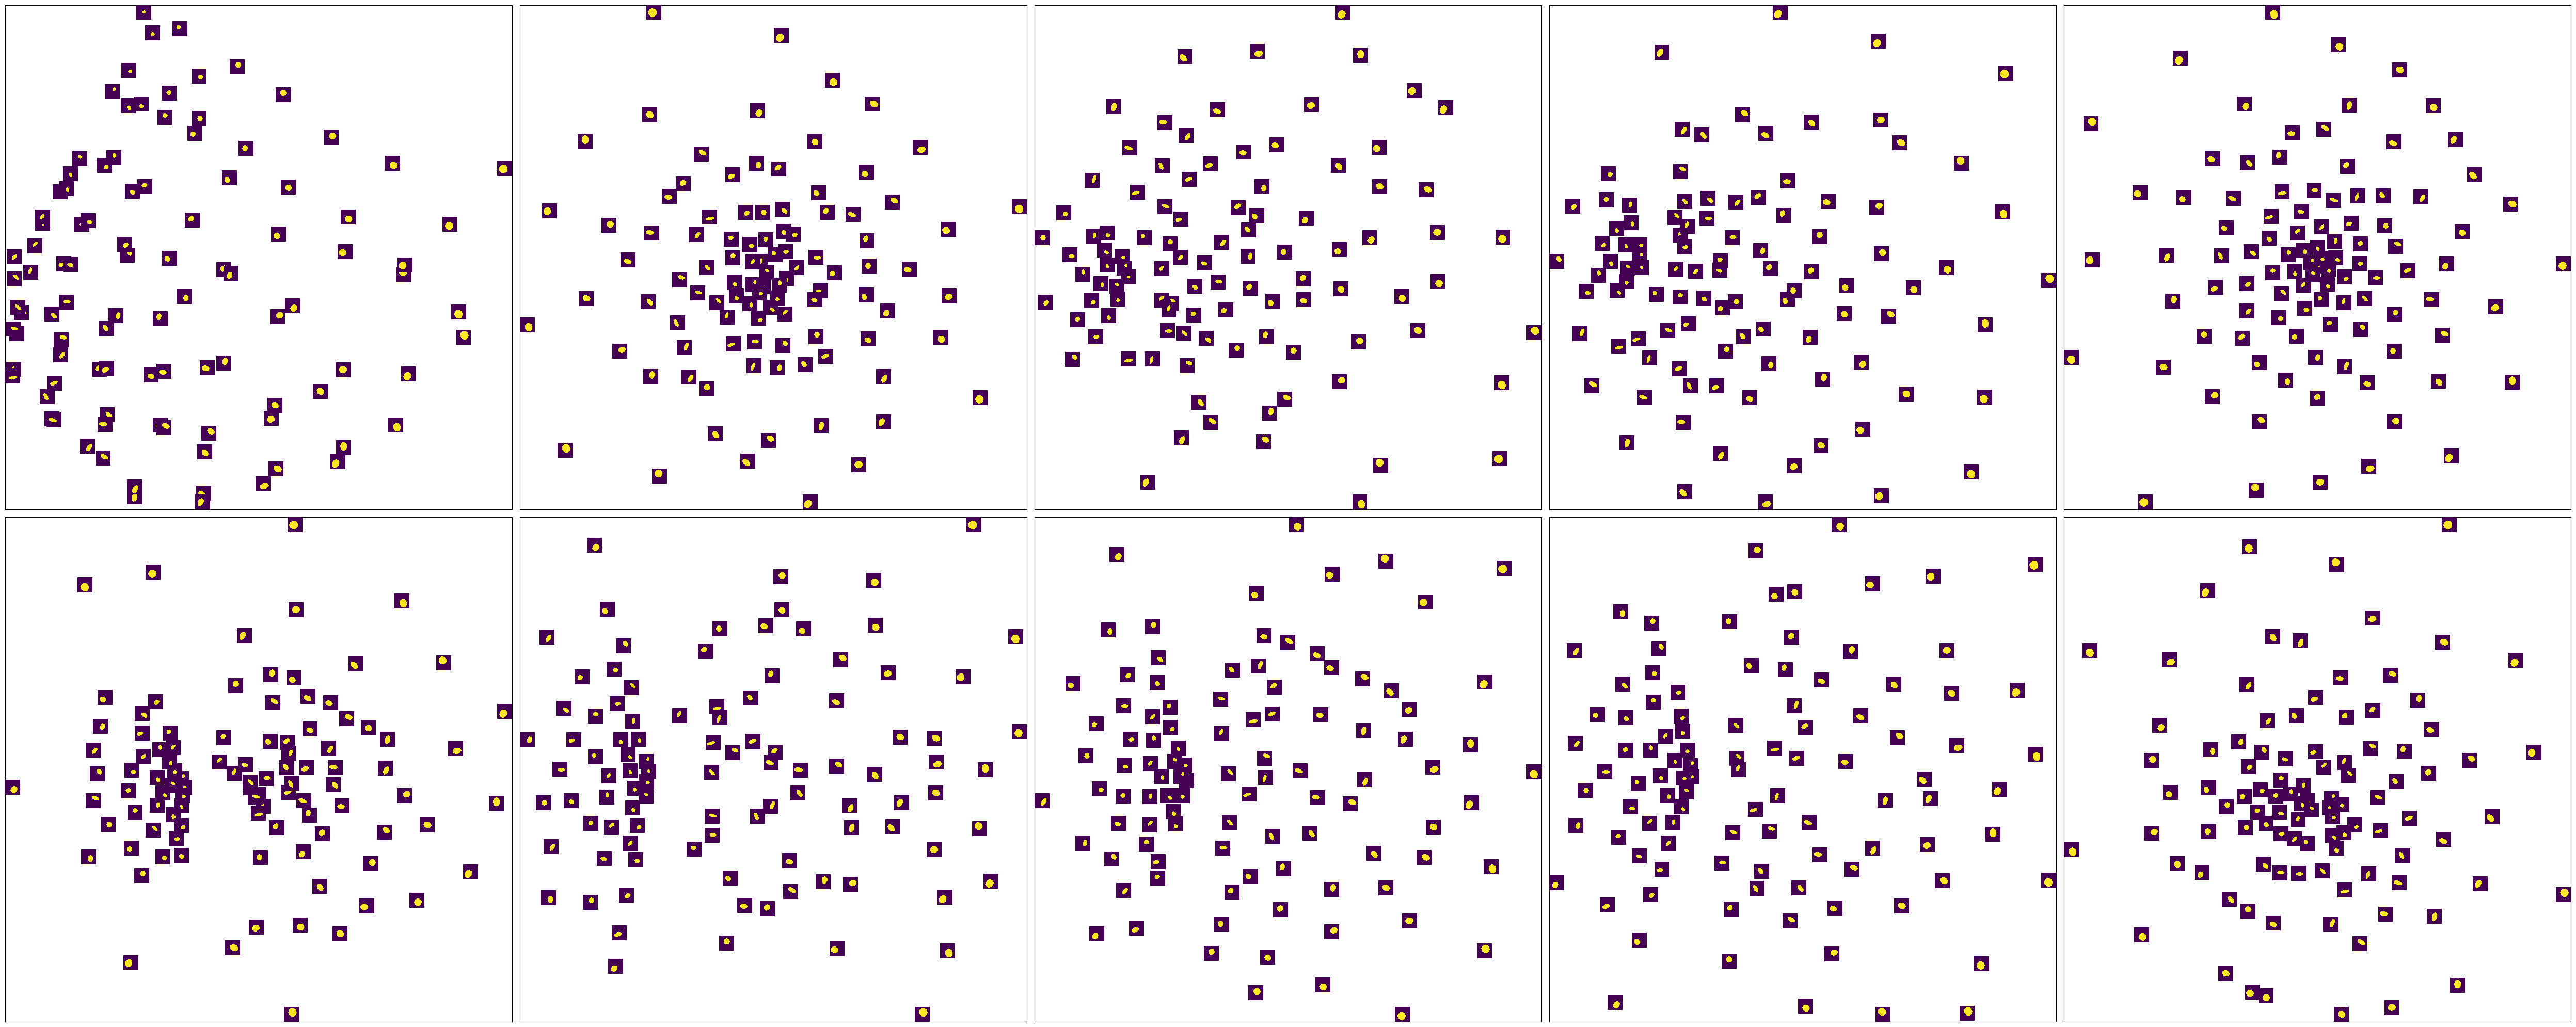

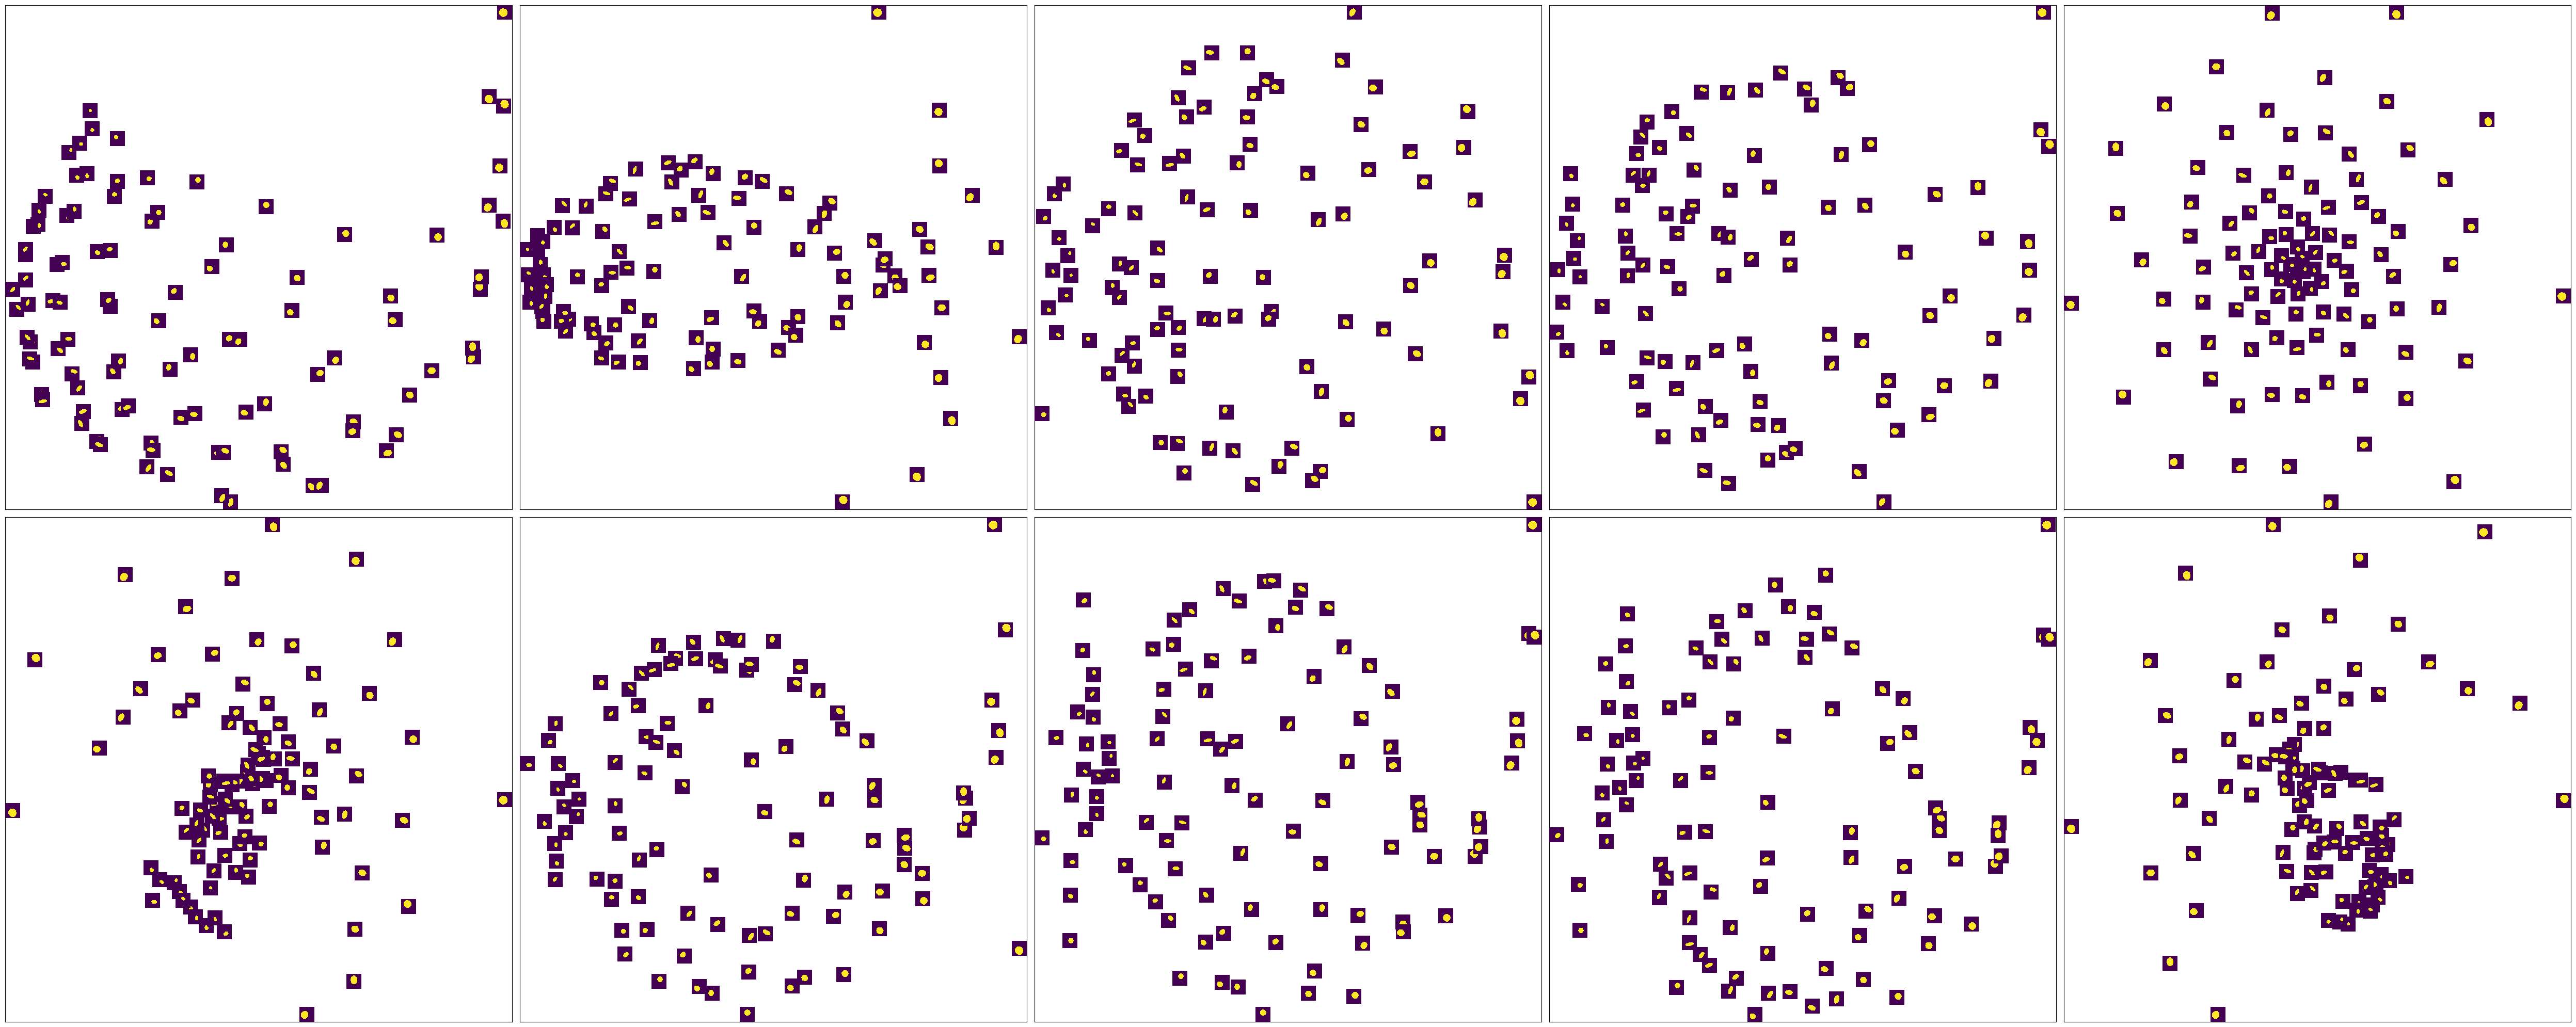

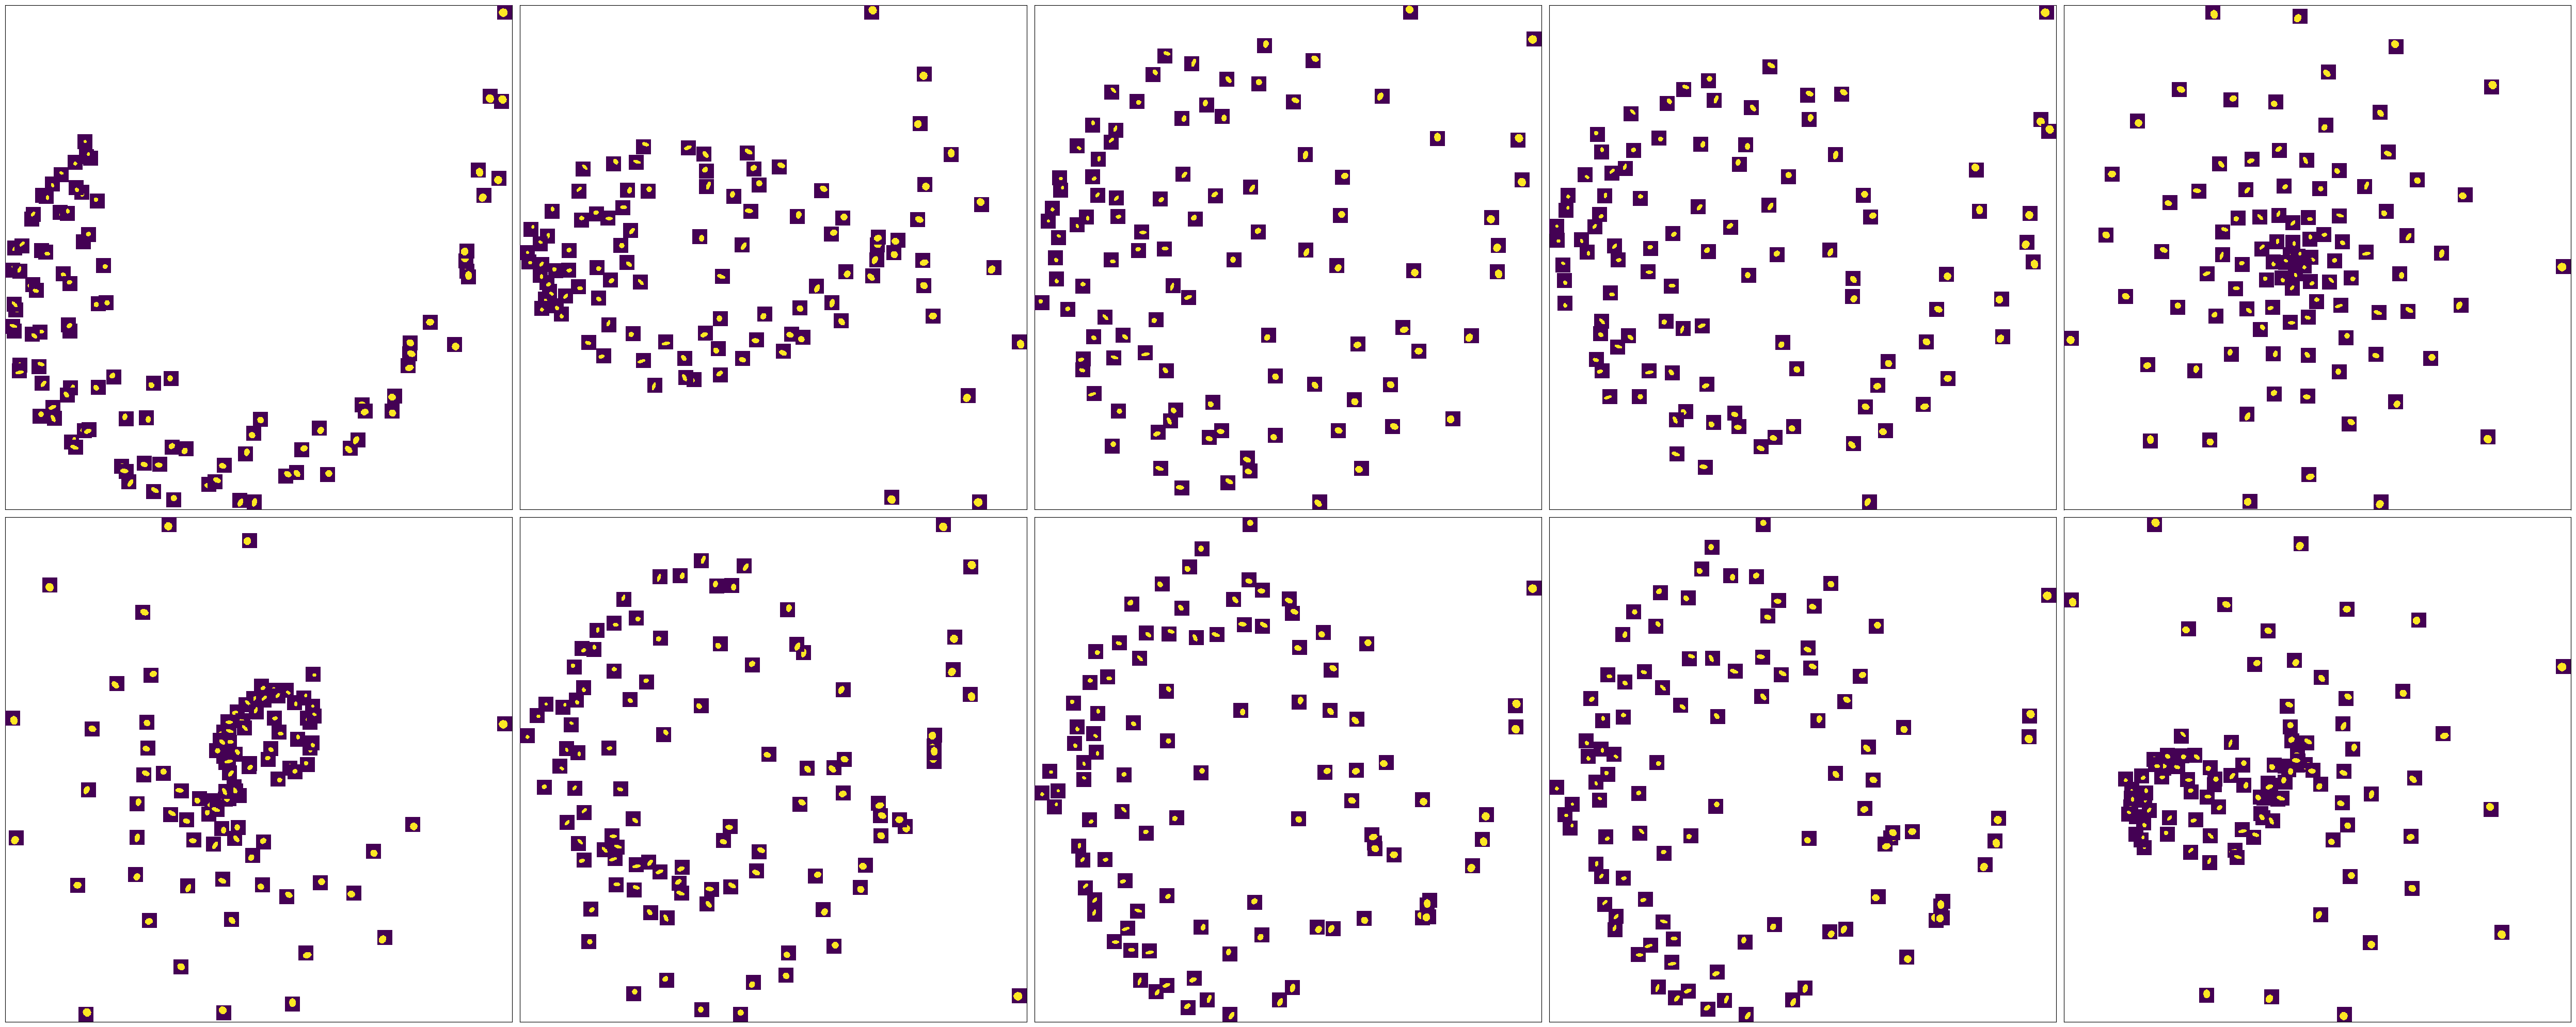

In [60]:
for Lambda in [0.007,0.100,1.000]:
    result=torch.load('results/pgw_%0.3f.pt'%Lambda)
    pgw=result['dist']
    result=torch.load('results/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    clf=PCA(n_components=2)
    #plot ref spaces, associated LGW distances and MDS embeddings
    fig, ax = plt.subplots(2,5, figsize = (50,20))

    for i in range(5):
        ax[0,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        ax[1,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0,normalized_stress='auto')
    
       
        if i == 0:
            dist=pgw
        else:
            dist = lpgw_per_ref[i-1]
        #plot
        embedding1=smacof_mds(dist,2)
        embedding1=clf.fit_transform(embedding1.copy())
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])
    
        dist=lpgw_per_ref[i+4]
        embedding2=smacof_mds(dist,2)
        embedding2=clf.fit_transform(embedding2.copy())
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
    plt.tight_layout()
    plt.savefig("results/lpgw_%0.3f.png"%Lambda)
    plt.show()

In [82]:
for Lambda in [0.007,0.100,1.000]:
    result=torch.load('results/pgw_%0.3f.pt'%Lambda)
    pgw=result['dist']
    result=torch.load('results/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    
    print("        MRE       PCC      time in mins     no. of points")
    for i in range(9):
        m_pgw = np.ma.masked_equal(pgw, 0.0, copy=False)
        m_lpgw = np.ma.masked_equal(lgw_per_ref[i], 0.0, copy=False)
        print("Ref " + str(i+1) + ":  " 
              + str(np.round(np.mean(np.abs(m_pgw - m_lpgw)/m_gw),4)) 
              + "    " 
              + str(np.round(np.corrcoef(m_pgw.flatten(),m_lpgw.flatten())[1,0],4))
              + "    "
              + str(np.round((times_per_ref[i])/60,2))
              + "             "
              + str(np.sum(imgs[i] != 0)))

        MRE       PCC      time in mins     no. of points


ValueError: operands could not be broadcast together with shapes (5,5) (100,100) 

In [70]:
np.ma.masked_equal(pgw, 0.0, copy=False)

masked_array(
  data=[[--, 0.345210818379991, 0.5790138974427497, ...,
         2.7585040328223887, 3.005985450816202, 3.248551058144217],
        [0.345210818379991, --, 0.44709405660349266, ...,
         2.720202694718103, 2.9804865958855236, 3.244405490447009],
        [0.5790138974427497, 0.44709405660349266, --, ...,
         2.726288808408587, 3.0005996986806656, 3.28339887154619],
        ...,
        [2.7585040328223887, 2.720202694718103, 2.726288808408587, ...,
         --, 1.2523989194689078, 1.789027262261425],
        [3.005985450816202, 2.9804865958855236, 3.0005996986806656, ...,
         1.2523989194689078, --, 1.2859220600964891],
        [3.248551058144217, 3.244405490447009, 3.28339887154619, ...,
         1.789027262261425, 1.2859220600964891, --]],
  mask=[[ True, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  

In [43]:
WEIGHT=300.0
#Compute LPGW distances for all reference measures
def LPGW_dist(embedding1,embedding2,Lambda):
    (K1_tilde,p1_tilde,mass_p1c),(K2_tilde,p2_tilde,mass_p2c)=embedding1,embedding2
    p12=np.minimum(p1_tilde,p2_tilde)
    M=(K1_tilde-K2_tilde)**2 
    dist=p12.dot(M).dot(p12.reshape(-1,1))[0]
    penalty_1=Lambda*(p1_tilde.sum()**2+p2_tilde.sum()**2-2*p12.sum()**2)
    penalty_2=Lambda*(mass_p1c+mass_p2c)
    return dist, penalty_1+penalty_2

refs=torch.load('results/refs.pt')
N=100
idx = 0
for Lambda in [0.007,0.1,1.0]:
    Gs_per_ref = []
    dist_per_ref = []
    times_per_ref = []
    embedding_per_ref = []
    for k in range(len(refs)):
        embeddings=[]
        supp,M,height = refs[k]
        Gs = []
        BPs = []
        st = time.time()
        height1=height/WEIGHT
        n=height1.shape[0]
        for i in range(N):
            #compute the embedding
            height2=heights[i]/WEIGHT
            supp2= posns[i]
            #Compute Wasserstein coupling
            M_ot = ot.dist(supp,posns[i])
            G0,_= opt_lp(height1,height2,M_ot,Lambda)
        
            #Compute GW coupling with initial coupling set to Wasserstein coupling G0
            #constC, hC1, hC2 = init_matrix(M, Ms[i], height, heights[i], "square_loss")

            G =partial_gromov_ver1(M, Ms[i], height1, height2, G0=G0,Lambda=Lambda,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=True) 
            
            embedding,_=LPGW_embedding(M,supp2,height1,height2,Lambda,gamma=G,loss=loss)
            embeddings.append(embedding)

            
        dist = np.zeros((N,N))
        for i in range(N):
            embedding1=embeddings[i]
            for j in range(i + 1, N):
                embedding2=embeddings[j]
                trans,penalty=LPGW_dist(embedding1,embedding2,Lambda)
                dist[i, j] = np.sqrt(trans+penalty)

        dist += dist.T
        et = time.time()
        print("Time for LPGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")

        times_per_ref.append(et-st)
        dist_per_ref.append(dist)

    result={}
    result['dist_per_ref'],result['times_per_ref']=dist_per_ref,times_per_ref
    torch.save(result,'results/lpgw_%0.3f.pt'%Lambda)


Time for LPGW with ref space 0: 0.61 min
Time for LPGW with ref space 1: 1.14 min
Time for LPGW with ref space 2: 1.11 min
Time for LPGW with ref space 3: 0.11 min
Time for LPGW with ref space 4: 0.67 min
Time for LPGW with ref space 5: 0.86 min
Time for LPGW with ref space 6: 1.84 min
Time for LPGW with ref space 7: 1.84 min
Time for LPGW with ref space 8: 0.57 min
Time for LPGW with ref space 0: 0.27 min
Time for LPGW with ref space 1: 0.66 min
Time for LPGW with ref space 2: 0.59 min
Time for LPGW with ref space 3: 0.07 min
Time for LPGW with ref space 4: 0.32 min
Time for LPGW with ref space 5: 0.88 min
Time for LPGW with ref space 6: 1.18 min
Time for LPGW with ref space 7: 1.17 min
Time for LPGW with ref space 8: 0.38 min
Time for LPGW with ref space 0: 0.27 min
Time for LPGW with ref space 1: 0.66 min
Time for LPGW with ref space 2: 0.59 min
Time for LPGW with ref space 3: 0.07 min
Time for LPGW with ref space 4: 0.4 min
Time for LPGW with ref space 5: 0.88 min
Time for LPGW wit

pgw is [0.         0.09859289 0.18156763 0.19254834 0.22676201 0.25881484
 0.26943156 0.28177384 0.29187855 0.31107036 0.11298148 0.09568778
 0.13327923 0.17689606 0.21816016 0.24365459 0.26323123 0.29080846
 0.30532743 0.32268582 0.16852867 0.13322904 0.1240173  0.16061193
 0.2008533  0.23577334 0.26805139 0.2957679  0.31317212 0.33108118
 0.19115757 0.17210931 0.1477837  0.16017804 0.18544723 0.22808626
 0.27210389 0.29770793 0.3215451  0.35565201 0.22492481 0.21817008
 0.20207137 0.18267722 0.18263571 0.22091285 0.25723238 0.29794992
 0.33418129 0.3572688  0.24146449 0.24306711 0.22926207 0.24195014
 0.21771908 0.22240797 0.25395646 0.29083515 0.32798715 0.35575026
 0.25823381 0.27797703 0.27239057 0.26290998 0.26305922 0.2603272
 0.26282882 0.29330098 0.33854711 0.37371126 0.2810411  0.28841434
 0.29077819 0.29614358 0.2968104  0.29427782 0.30103013 0.30618967
 0.33154456 0.38219569 0.29182617 0.31382061 0.31991746 0.31936894
 0.32721309 0.32997606 0.3401019  0.33529253 0.35210419 

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


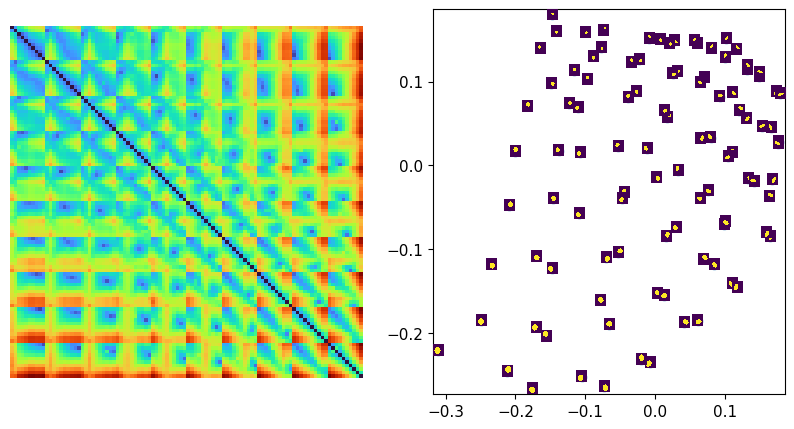

lpgw is [0.         0.04092799 0.04529398 0.04734178 0.05179865 0.05664696
 0.06011609 0.06617611 0.06873581 0.07364509 0.03967745 0.04439907
 0.05013759 0.05251666 0.05862262 0.06338279 0.07053793 0.07703383
 0.08044322 0.08519337 0.04329485 0.04896427 0.05566637 0.06086634
 0.06414212 0.07260701 0.07965474 0.08519337 0.09237213 0.09424224
 0.04780284 0.05323814 0.06036592 0.06745369 0.07208883 0.08281432
 0.08837672 0.09424224 0.10309947 0.10984737 0.05108424 0.05911937
 0.06617611 0.07286632 0.08070626 0.08837672 0.0958478  0.10390765
 0.1144513  0.12178506 0.05664696 0.06439565 0.07182997 0.08228669
 0.09023913 0.09852873 0.10687474 0.11418017 0.12396254 0.13323663
 0.060616   0.07028    0.08018028 0.09050549 0.09772382 0.10633485
 0.1171646  0.12695962 0.13350984 0.14747173 0.06541186 0.07494583
 0.08545818 0.0958478  0.10633485 0.11662166 0.12805029 0.13870512
 0.14692326 0.15900454 0.06822243 0.08149601 0.0931732  0.10363821
 0.11309603 0.12423486 0.13761072 0.14802027 0.1598293

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


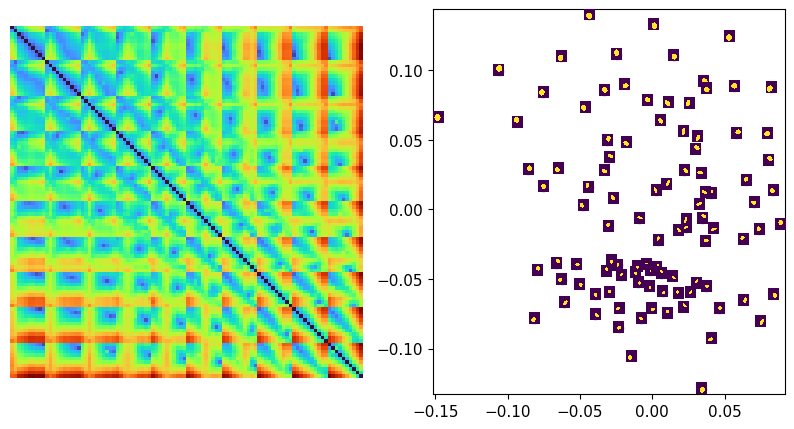

pgw is [0.         0.15895023 0.28041619 0.3047262  0.364941   0.42359886
 0.45096537 0.49131744 0.51329955 0.5542163  0.16202455 0.18392008
 0.25813664 0.31596302 0.38947189 0.43851109 0.49063394 0.54704658
 0.57654154 0.61412698 0.25231215 0.25153585 0.2784963  0.34107145
 0.39742016 0.47086629 0.53434339 0.58588254 0.63334131 0.65961883
 0.30593126 0.3149934  0.32580766 0.37132771 0.41753743 0.50680768
 0.57463588 0.62483394 0.68492585 0.74684297 0.35988398 0.39198769
 0.40787573 0.41817249 0.45211447 0.52286447 0.59028149 0.66418068
 0.74301511 0.79555324 0.40537215 0.44234698 0.46092402 0.51865198
 0.52741934 0.56627049 0.63177982 0.69814437 0.77441073 0.83890537
 0.44140272 0.50450941 0.54092649 0.57409357 0.60382266 0.63599489
 0.68194806 0.75138014 0.82259531 0.91259201 0.48750231 0.53570675
 0.58195048 0.62982095 0.67279004 0.71132558 0.76342316 0.81056208
 0.86813986 0.96597071 0.5110269  0.58988008 0.64346469 0.68499591
 0.73057852 0.77749978 0.84023607 0.87617635 0.93902635

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


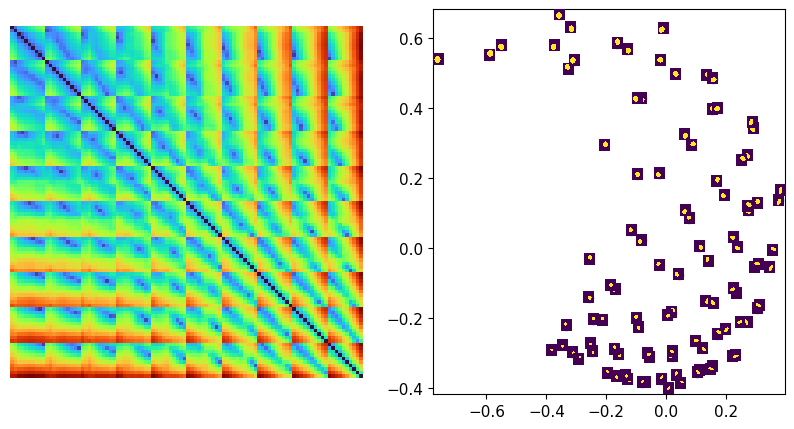

lpgw is [0.         0.15469324 0.17119515 0.17893512 0.19578049 0.21410537
 0.22721747 0.25012219 0.25979693 0.27835229 0.14996666 0.16781273
 0.18950227 0.19849433 0.22157266 0.23956442 0.26660833 0.29116051
 0.30404678 0.32200069 0.16363917 0.18506756 0.21039909 0.23005313
 0.24243441 0.2744287  0.30106662 0.32200069 0.34913385 0.35620219
 0.18067774 0.20122127 0.22816174 0.25495098 0.27247018 0.3130087
 0.3340326  0.35620219 0.38967936 0.41518403 0.19308029 0.22345022
 0.25012219 0.27540879 0.30504098 0.3340326  0.36227062 0.39273401
 0.43258525 0.46030425 0.21410537 0.24339269 0.27149176 0.31101447
 0.34107184 0.3724036  0.40394857 0.43156048 0.46853436 0.50358713
 0.22910696 0.26563341 0.30305298 0.34207861 0.36936131 0.40190795
 0.44284058 0.47986225 0.50461977 0.55739075 0.24723358 0.28326862
 0.32300155 0.36227062 0.40190795 0.44078844 0.48398462 0.52425609
 0.55531773 0.60098068 0.25785655 0.30802597 0.35216158 0.3917156
 0.4274628  0.46956363 0.52011964 0.55946403 0.60409804 

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


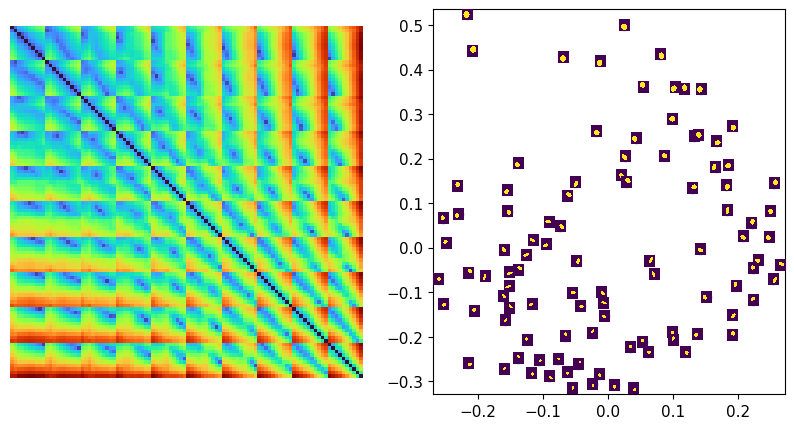

pgw is [0.         0.34521082 0.5790139  0.64593563 0.78890259 0.92897375
 1.01068335 1.14142399 1.20043655 1.31073674 0.30516811 0.4612555
 0.65116257 0.75141637 0.92508155 1.04692629 1.2027519  1.34981902
 1.42579833 1.5272414  0.50470009 0.62292042 0.76630115 0.91077807
 1.01652316 1.21164204 1.37241346 1.49861195 1.64093166 1.69186735
 0.65614977 0.76277323 0.88785084 1.03860889 1.15082172 1.38722556
 1.52931153 1.65663403 1.83138805 1.97977053 0.77148327 0.93537212
 1.0567867  1.16234183 1.30402339 1.47735637 1.64278409 1.82088504
 2.03413676 2.17927765 0.91057613 1.06568675 1.19079884 1.39204417
 1.50648236 1.65350617 1.82635108 1.98569507 2.1853303  2.36583656
 1.00853661 1.21306211 1.3861256  1.55678132 1.680693   1.82367171
 2.00720688 2.19980222 2.35287394 2.616186   1.12656387 1.30965994
 1.49813728 1.68251106 1.86056557 2.02975602 2.22549611 2.40545128
 2.56490576 2.81179661 1.19083494 1.45348233 1.66157241 1.83839657
 2.00451089 2.19184327 2.42154382 2.58650827 2.79498099 

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


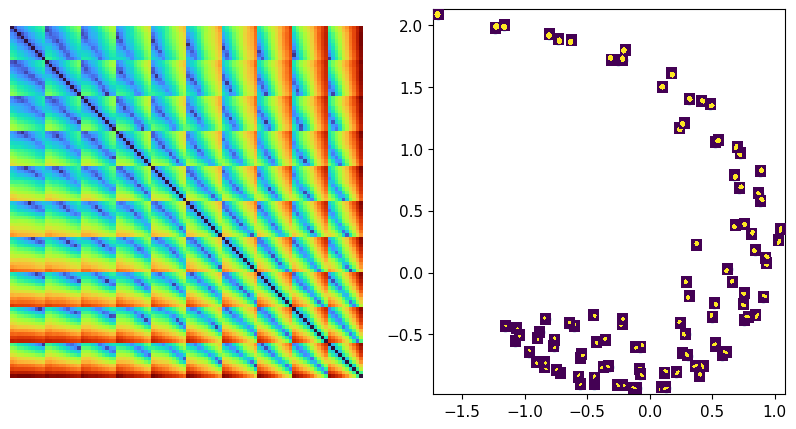

lpgw is [0.         0.48918299 0.54136658 0.56584254 0.61911227 0.67706064
 0.71852472 0.79095582 0.82155003 0.88022724 0.47423623 0.53067044
 0.5992588  0.62769419 0.70067428 0.75756921 0.84308956 0.92073039
 0.96148034 1.01825559 0.51747249 0.585235   0.66534035 0.72749189
 0.76664493 0.86781975 0.95205625 1.01825559 1.10405817 1.12641023
 0.57135317 0.63631753 0.72151076 0.80622577 0.86162637 0.98982041
 1.05630383 1.12641023 1.23227432 1.31292718 0.6105735  0.70661163
 0.79095582 0.87091905 0.96462428 1.05630383 1.14560028 1.24193398
 1.36795468 1.45560984 0.67706064 0.76967526 0.85853234 0.98351411
 1.07856386 1.1776436  1.27739753 1.36471405 1.48163573 1.59248234
 0.72449983 0.84000661 0.95833768 1.08174756 1.16802302 1.27094453
 1.40038487 1.51745767 1.59574782 1.76262431 0.78182124 0.89577403
 1.02142058 1.14560028 1.27094453 1.39389542 1.53049375 1.65784331
 1.75606884 1.90046778 0.81541401 0.97406365 1.11363269 1.23871349
 1.35175606 1.48489057 1.64476273 1.7691806  1.9103257

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


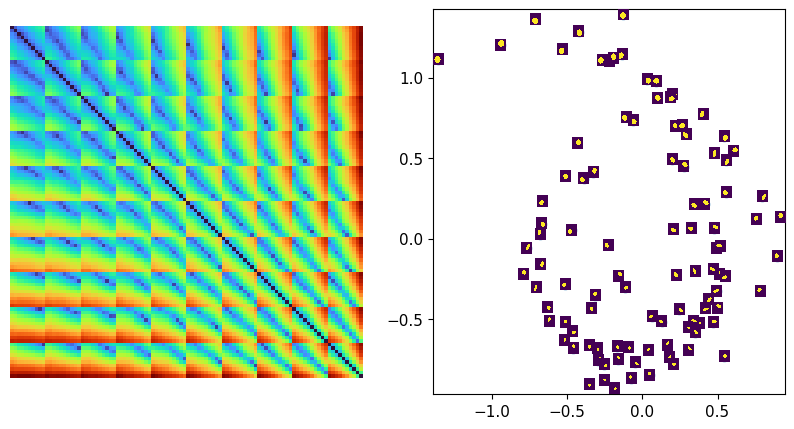

In [69]:
for per in [0.007,0.1,1.0]:
    result=torch.load('results/pgw_%0.3f.pt'%per)
    pgw=result['dist']
    print('pgw is', pgw[0,:])
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(pgw,cmap = "turbo")
    ax[0].axis("off")


    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
    embedding = mds.fit_transform(pgw)
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

    ax[1].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.show()


    result=torch.load('results/lpgw_%0.3f.pt'%per)
    lpgw=result['dist_per_ref'][5]
    print('lpgw is',lpgw[0,:])
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(pgw,cmap = "turbo")
    ax[0].axis("off")


    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
    embedding = mds.fit_transform(lpgw)
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

    ax[1].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.show()

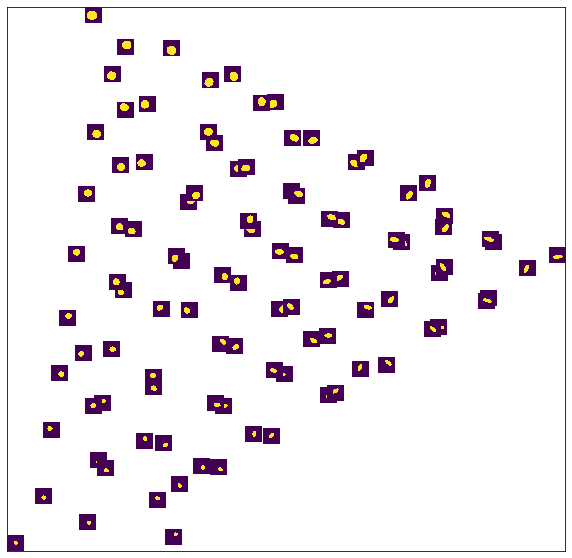

In [40]:
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
utils.plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


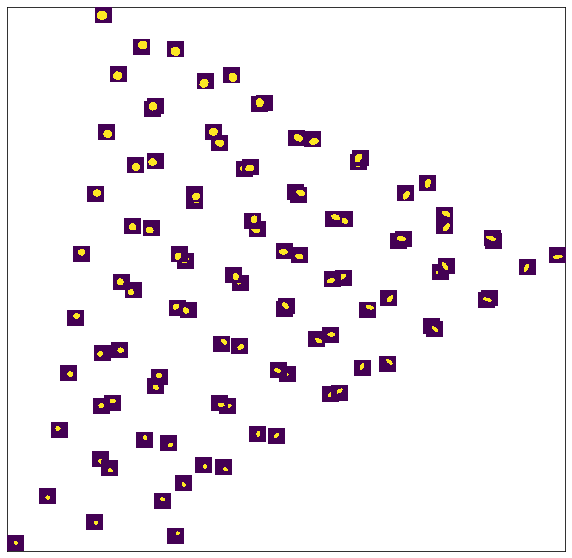

In [37]:
i = 8
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding2 = mds.fit_transform(LGW_per_ref[i])
utils.plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


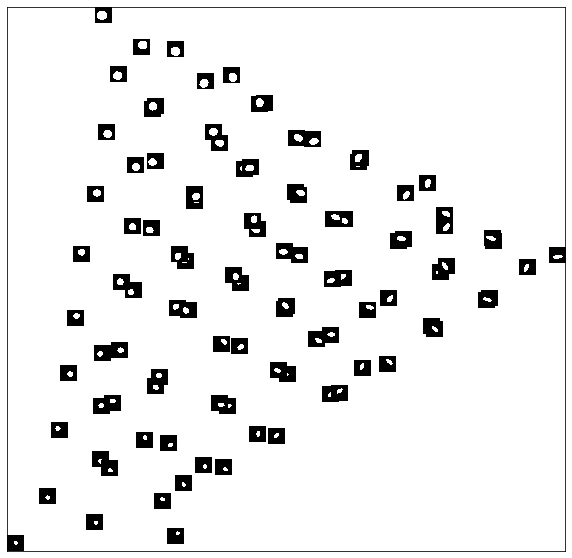

In [28]:
i = 8
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding2 = mds.fit_transform(LGW_per_ref[i])
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


In [9]:
print("        MRE       PCC      time in mins     no. of points")
for i in range(9):
    m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
    m_lgw = np.ma.masked_equal(LGW_per_ref[i], 0.0, copy=False)
    print("Ref " + str(i+1) + ":  " 
          + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)) 
          + "    " 
          + str(np.round(np.corrcoef(gw.flatten(),m_lgw.flatten())[1,0],4))
          + "    "
          + str(np.round((times_per_ref[i])/60,2))
          + "             "
          + str(np.sum(imgs[i] != 0)))

        MRE       PCC      time in mins     no. of points


NameError: name 'gw' is not defined

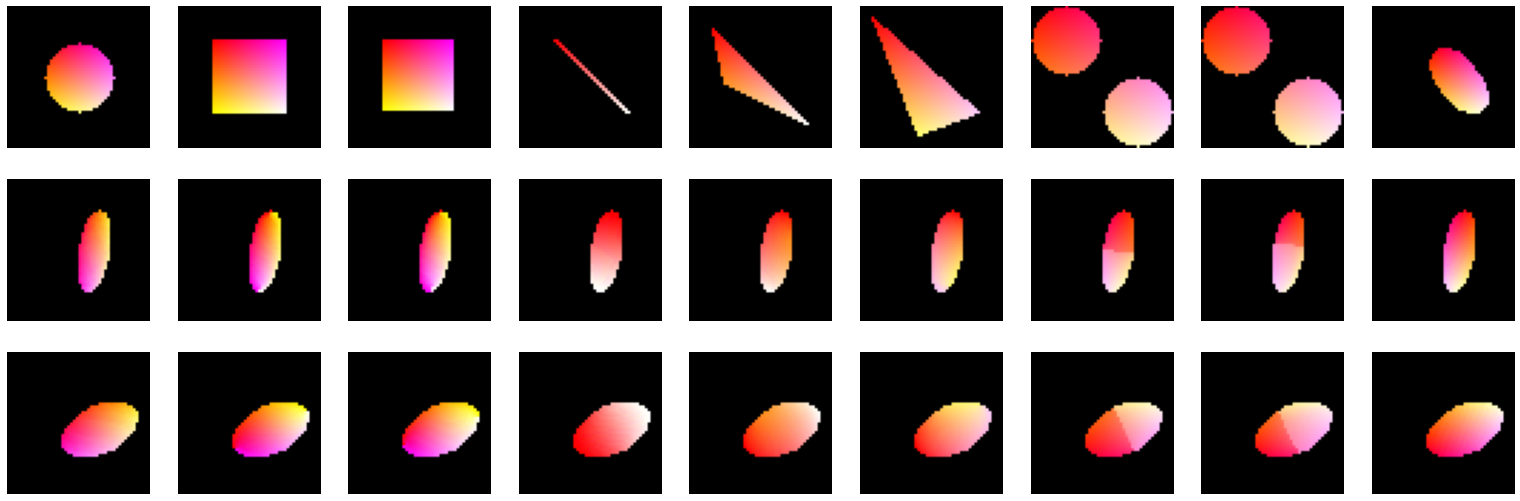

In [23]:
fig, ax = plt.subplots(3,9,figsize=(27,9))
nos = [90,93]
for i in range(9):
    img1,img2 = vis_gw_plan(imgs[i],refs[i][0],posns[nos[0]],ot.unif(len(posns[nos[0]])),Ps_per_ref[i][nos[0]],return_img=True,plot_img=False,sub_box=True)   
    ax[0,i].imshow(img1)
    ax[0,i].axis("off")
    
    ax[1,i].imshow(img2)
    ax[1,i].axis("off")
    
    img3 = vis_gw_plan(imgs[i],refs[i][0],posns[nos[1]],ot.unif(len(posns[nos[1]])),Ps_per_ref[i][nos[1]],return_img=True,plot_img=False,sub_box=True)[1]   
    ax[2,i].imshow(img3)
    ax[2,i].axis("off")